<a href="https://colab.research.google.com/github/blparish/Confluence-Test--Training-Evaluation/blob/main/Train_Cellpose_SAM_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


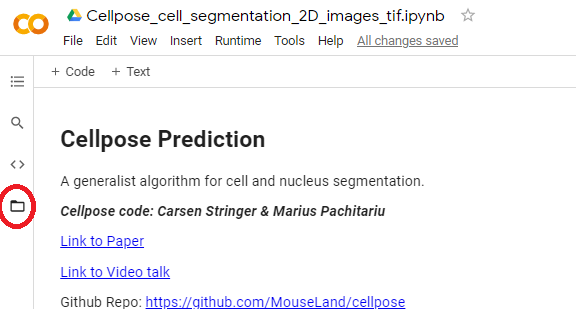

Remove Overlaps from LiveCell Data set

Check GPU and instantiate model - will download weights.

In [ ]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
import torch

io.logger_setup()

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-07-09 03:26:53,035 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-09 03:26:53,035 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-09 03:26:53,036 [INFO] ** TORCH CUDA version installed and working. **
2025-07-09 03:26:53,037 [INFO] ** TORCH CUDA version installed and working. **
2025-07-09 03:26:53,037 [INFO] >>>> using GPU (CUDA)
2025-07-09 03:26:55,747 [INFO] >>>> loading model /root/.cellpose/models/cpsam


Input directory with your images (if you have them, otherwise use sample images):

In [ ]:
from pathlib import Path
from skimage import io

# paths
train_dir = Path("/content/drive/MyDrive/Images/Train")
val_dir   = Path("/content/drive/MyDrive/Images/Validation")
test_dir  = Path("/content/drive/MyDrive/Images/Test")

for p in (train_dir, val_dir, test_dir):
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")

masks_ext = "_masks.png"

# training split
train_imgs = sorted(train_dir.glob("*_img.png"))
train_masks = sorted(train_dir.glob(f"*{masks_ext}"))

# validation split
val_imgs = sorted(val_dir.glob("*_img.png"))
val_masks = sorted(val_dir.glob(f"*{masks_ext}"))

# exclude model-generated artefacts (train only)
files = [f for f in train_dir.glob("*")
         if not any(tag in f.name for tag in ["_SAMseg", "_Cyto3seg",
                                              "_Nucleiseg", "_flows", "_seg"])]

if not train_imgs: raise FileNotFoundError("No raw images in Train folder")
if not train_masks: raise FileNotFoundError("No masks in Train folder")
if not val_imgs:   raise FileNotFoundError("No raw images in Validation folder")
if not val_masks:  raise FileNotFoundError("No masks in Validation folder")

print(f"Train: {len(train_imgs)} imgs / {len(train_masks)} masks")
print(f"Val  : {len(val_imgs)} imgs / {len(val_masks)} masks")

sample_mask = io.imread(str(train_masks[0]))
print(f"Sample mask shape {sample_mask.shape}, min {sample_mask.min()}, max {sample_mask.max()}")


Train: 472 imgs / 472 masks
Val  : 68 imgs / 68 masks
Sample mask shape (383, 512), min 0, max 90


## Train new model

In [ ]:
from cellpose import train, io, models

# Ensure train_dir, test_dir, and masks_ext are defined, for example:
train_dir = "/content/drive/MyDrive/Images/Train"
val_dir   = "/content/drive/MyDrive/Images/Validation"
test_dir  = "/content/drive/MyDrive/Images/Test"   # keep untouched for final eval

# In this naming convention, images are named like "xxx_img.png" and masks "xxx_masks.png"

model_name = "Confluence_10epoch"

# Default training parameters
n_epochs = 10
learning_rate = 1e-5
weight_decay = 0.1
batch_size = 8
drive_root = Path("/content/drive/MyDrive/Models")   # your Drive folder


In [ ]:
# Load training + validation pairs instead of training + test
output = io.load_train_test_data(
    str(train_dir),          # Train
    str(val_dir),            # Validation
    image_filter="_img",
    mask_filter="_masks"
)

train_data, train_labels, _, val_data, val_labels, _ = output

2025-06-29 14:24:16,324 [INFO] not all flows are present, running flow generation for all images
2025-06-29 14:25:27,703 [INFO] 472 / 472 images in /content/drive/MyDrive/GWU/Praxis/Images/Praxis Cleanup/Train folder have labels
2025-06-29 14:25:27,734 [INFO] not all flows are present, running flow generation for all images
2025-06-29 14:25:44,635 [INFO] 68 / 68 images in /content/drive/MyDrive/GWU/Praxis/Images/Praxis Cleanup/Validation folder have labels


In [ ]:
# Initialise the Cellpose model (using pretrained 'cyto' weights as an example)
model = models.CellposeModel(pretrained_model="cyto", gpu=True)
net   = model.net.to("cuda")          # move weights to GPU

# Train with the validation split (val_data / val_labels)
new_model_path, train_losses, val_losses = train.train_seg(
    net,
    train_data     = train_data,
    train_labels   = train_labels,
    test_data      = val_data,        # ← validation images
    test_labels    = val_labels,      # ← validation masks
    batch_size     = batch_size,
    n_epochs       = n_epochs,
    learning_rate  = learning_rate,
    weight_decay   = weight_decay,
    nimg_per_epoch = max(2, len(train_data)),
    save_every     = 5,
    save_path      = str(drive_root),
    model_name     = model_name
)

print(f"Model saved at: {new_model_path}")


2025-06-28 19:57:28,185 [INFO] ** TORCH CUDA version installed and working. **
2025-06-28 19:57:28,185 [INFO] >>>> using GPU (CUDA)
2025-06-28 19:57:28,186 [WARNING] pretrained model /root/.cellpose/models/cpsam not found, using default model
2025-06-28 19:57:30,624 [INFO] >>>> loading model /root/.cellpose/models/cpsam
2025-06-28 19:57:31,219 [INFO] computing flows for labels


100%|██████████| 472/472 [00:38<00:00, 12.11it/s]

2025-06-28 19:58:10,412 [INFO] computing flows for labels



100%|██████████| 68/68 [00:05<00:00, 12.74it/s]

2025-06-28 19:58:15,781 [INFO] >>> computing diameters



100%|██████████| 68/68 [00:00<00:00, 1127.67it/s]

2025-06-28 19:58:16,292 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-06-28 19:58:19,736 [INFO] >>> n_epochs=10, n_train=472, n_test=68
2025-06-28 19:58:19,737 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-06-28 19:58:19,741 [INFO] >>> saving model to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/models/Confluence_10epoch
2025-06-28 19:59:35,019 [INFO] 0, train_loss=0.6777, test_loss=0.5986, LR=0.000000, time 75.28s
2025-06-28 20:05:31,605 [INFO] 5, train_loss=0.6823, test_loss=0.5979, LR=0.000006, time 431.87s
2025-06-28 20:05:31,606 [INFO] saving network parameters to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/models/Confluence_10epoch
2025-06-28 20:10:14,869 [INFO] saving network parameters to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/models/Confluence_10epoch
Model saved at: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/models/Confluence_10epoch


Creating varius tuning models

In [ ]:
# paths
from pathlib import Path
from itertools import product
from cellpose import io, train, models, core
import torch, gc, datetime

root_img  = Path("/content/drive/MyDrive/Images")
train_dir = root_img / "Train"
val_dir   = root_img / "Validation"

out_root  = Path("/content/drive/MyDrive/Models/Grid")
out_root.mkdir(parents=True, exist_ok=True)

assert core.use_gpu(), " No GPU detected"

#hyper-parameter sweep
grid = {
    "epochs"      : [30, 50],
    "lr"          : [1e-4, 5e-5],
    "weight_decay": [0.01, 0.1],
    "batch"       : [8, 16]
}

# one channel pairing for all runs (green cytoplasm, no nuclei)
CHANNELS = [1, 0]


2025-06-29 01:59:43,753 [INFO] ** TORCH CUDA version installed and working. **


In [ ]:
from cellpose import io

train_imgs, train_masks, train_files, val_imgs, val_masks, val_files = io.load_train_test_data(
    str(train_dir),          # 472 images
    str(val_dir),            # 68 images
    image_filter="_img",
    mask_filter="_masks"
)

print(f"Loaded: {len(train_imgs)} train, {len(val_imgs)} val images")
assert len(val_imgs) == 68, "Validation set should be 68 images"


2025-06-30 22:35:34,336 [INFO] not all flows are present, running flow generation for all images
2025-06-30 22:36:34,232 [INFO] 472 / 472 images in /content/drive/MyDrive/GWU/Praxis/Images/Praxis Cleanup/Train folder have labels
2025-06-30 22:36:34,264 [INFO] not all flows are present, running flow generation for all images
2025-06-30 22:36:46,496 [INFO] 68 / 68 images in /content/drive/MyDrive/GWU/Praxis/Images/Praxis Cleanup/Validation folder have labels
Loaded: 472 train, 68 val images


In [ ]:
from pathlib import Path
import numpy as np, skimage.io as skio
from tqdm import tqdm
from cellpose import dynamics   # flow generator

train_dir = Path("/content/drive/MyDrive/Images/Train")
val_dir   = Path("/content/drive/MyDrive/Images/Validation")

MASK_EXT = "_masks.png"
FLOW_EXT = "_flows.npy"
def uncached_masks(folder: Path):
    """Return a list of mask files that do *not* yet have a flow file."""
    miss = []
    for m in folder.glob(f"*{MASK_EXT}"):
        flow_path = m.with_name(m.stem + FLOW_EXT)
        if not flow_path.exists():
            miss.append(m)
    return miss

def cache_flows(mask_paths):
    """Generate and save flows for each mask in `mask_paths`."""
    for m in tqdm(mask_paths, desc="generate flows", unit="mask"):
        flow = dynamics.labels_to_flows([skio.imread(str(m))])[0]
        np.save(m.with_name(m.stem + FLOW_EXT), flow.astype(np.float32))

for folder in (train_dir, val_dir):
    todo = uncached_masks(folder)
    if not todo:
        print(f" {folder.name}: all flows already cached")
    else:
        print(f"{folder.name}: {len(todo)} masks missing flows → computing …")
        cache_flows(todo)

print(" done – every mask now has a cached *_flows.npy")


✓ Train: all flows already cached
✓ Validation: all flows already cached
✅ done – every mask now has a cached *_flows.npy


In [ ]:
from pathlib import Path
import torch, gc, numpy as np
from itertools import product
from cellpose import io, train, models

# paths
root_img  = Path("/content/drive/MyDrive/Images")
train_dir = root_img / "Train"
val_dir   = root_img / "Validation"

out_root  = Path("/content/drive/MyDrive/Models/Grid")
out_root.mkdir(parents=True, exist_ok=True)

# load train/val pairs (6-item return)
train_imgs, train_masks, _, val_imgs, val_masks, _ = io.load_train_test_data(
    str(train_dir), str(val_dir),
    image_filter="_img", mask_filter="_masks"
)

# hyper-parameter grid
grid = {
    "epochs"      : [30, 50],
    "lr"          : [1e-4, 5e-5],
    "weight_decay": [0.01, 0.1],
    "batch"       : [8]          # keep 8 to stay under VRAM
}

# sweep loop (flows already cached)
for epochs, lr, wd, batch in product(grid["epochs"],
                                     grid["lr"],
                                     grid["weight_decay"],
                                     grid["batch"]):

    run_name = f"e{epochs}_lr{lr:.0e}_wd{wd}_b{batch}"
    run_dir  = out_root / run_name
    save_dir = run_dir / "models"
    save_dir.mkdir(parents=True, exist_ok=True)

    final_ckpt = save_dir / f"{run_name}-epoch{epochs}.npy"
    if final_ckpt.exists():
        print(f"  {run_name} already trained — skipping")
        continue

    print(f"\n Training {run_name}")
    model = models.CellposeModel(pretrained_model="cpsam", gpu=True)
    net   = model.net.to("cuda")

    ckpt_path, tr_loss, val_loss = train.train_seg(
        net,
        train_imgs, train_masks,                 # positional
        test_data   = val_imgs,
        test_labels = val_masks,
        batch_size  = batch,
        n_epochs    = epochs,
        learning_rate  = lr,
        weight_decay   = wd,
        compute_flows  = False,                  # cached flows
        nimg_per_epoch = max(2, len(train_imgs)),
        save_every     = 5,
        save_path      = str(save_dir),
        model_name     = run_name
    )

    np.savez(run_dir / "losses.npz", train=tr_loss, val=val_loss)
    print("✓ saved to", ckpt_path)

    del model, net
    torch.cuda.empty_cache(); gc.collect()



▶️  Training e30_lr1e-04_wd0.01_b8


100%|██████████| 68/68 [00:00<00:00, 1121.30it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr1e-04_wd0.01_b8/models/models/e30_lr1e-04_wd0.01_b8

▶️  Training e30_lr1e-04_wd0.1_b8


100%|██████████| 68/68 [00:00<00:00, 1123.62it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr1e-04_wd0.1_b8/models/models/e30_lr1e-04_wd0.1_b8

▶️  Training e30_lr5e-05_wd0.01_b8


100%|██████████| 68/68 [00:00<00:00, 1149.71it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr5e-05_wd0.01_b8/models/models/e30_lr5e-05_wd0.01_b8

▶️  Training e30_lr5e-05_wd0.1_b8


100%|██████████| 68/68 [00:00<00:00, 1130.71it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr5e-05_wd0.1_b8/models/models/e30_lr5e-05_wd0.1_b8

▶️  Training e50_lr1e-04_wd0.01_b8


100%|██████████| 68/68 [00:00<00:00, 1146.65it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr1e-04_wd0.01_b8/models/models/e50_lr1e-04_wd0.01_b8

▶️  Training e50_lr1e-04_wd0.1_b8


100%|██████████| 68/68 [00:00<00:00, 1137.97it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr1e-04_wd0.1_b8/models/models/e50_lr1e-04_wd0.1_b8

▶️  Training e50_lr5e-05_wd0.01_b8


100%|██████████| 68/68 [00:00<00:00, 1143.86it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr5e-05_wd0.01_b8/models/models/e50_lr5e-05_wd0.01_b8

▶️  Training e50_lr5e-05_wd0.1_b8


100%|██████████| 68/68 [00:00<00:00, 1134.59it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr5e-05_wd0.1_b8/models/models/e50_lr5e-05_wd0.1_b8


In [ ]:
model = models.CellposeModel(gpu=True, pretrained_model="cpsam")
net   = model.net
net.freeze_encoder = True
freeze_epochs      = 5

ckpt, tr, va = train.train_seg(
    net,
    train_imgs,  train_masks,
    test_data  = val_imgs,
    test_labels= val_masks,
    n_epochs     = 80,
    learning_rate= 5e-4,
    weight_decay = 1e-3,
    batch_size   = 4,
    save_every   = 1,          # log every epoch
    compute_flows=False,       # use cached *_flows.npy
    flow_weight  = 1.0,
    seg_weight   = 0.5,
    freeze_encoder=freeze_epochs
)


In [ ]:
from pathlib import Path
from itertools import product
import numpy as np, torch, gc
from cellpose import io, train, models

root       = Path("/content/drive/MyDrive/Images")
train_dir  = root / "Train"
val_dir    = root / "Validation"

train_imgs, train_masks, _, val_imgs, val_masks, _ = io.load_train_test_data(
    str(train_dir), str(val_dir), image_filter="_img", mask_filter="_masks"
)

grid_root  = Path("/content/drive/MyDrive/Models/Grid")
grid_root.mkdir(parents=True, exist_ok=True)

grid = dict(
    lr        = [7e-4, 5e-4, 3e-4],   # only the values that matter most
    wd        = [1e-3],               # lower weight-decay worked better
    freeze_ep = [5],                  # keep encoder frozen for first 5 epochs
    epochs    = [80]                  # longer schedule for convergence
)

def latest_ckpt(run: Path):
    files = [p for p in run.rglob("*.npy") if p.name != "losses.npz"]
    return max(files, key=lambda p: p.stat().st_mtime) if files else None

for lr, wd, fe, ep in product(*grid.values()):
    run_name = f"e{ep}_lr{lr:.0e}_wd{wd}_b4_fe{fe}"
    run_dir  = grid_root / run_name
    save_dir = run_dir / "models"
    save_dir.mkdir(parents=True, exist_ok=True)

    if latest_ckpt(run_dir):
        print("skip", run_name, "– already trained")
        continue

    print("train", run_name)
    model = models.CellposeModel(pretrained_model="cpsam", gpu=True)
    net   = model.net.to("cuda")
    net.freeze_encoder, net.freeze_epochs = True, fe

    ckpt, tr_loss, val_loss = train.train_seg(
    net,
    train_imgs, train_masks,
    test_data     = val_imgs,
    test_labels   = val_masks,
    n_epochs      = ep,
    batch_size    = 4,
    learning_rate = lr,
    weight_decay  = wd,
    compute_flows = False,              # True if flows not saved
    nimg_per_epoch= max(2, len(train_imgs)),
    save_every    = 5,
    save_path     = str(save_dir),
    model_name    = run_name
)

    np.savez(run_dir / "losses.npz", train=tr_loss, val=val_loss)
    print("✓ saved to", ckpt)

    del model, net
    torch.cuda.empty_cache(); gc.collect()




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6.dev2+g992d7b4 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


train e80_lr7e-04_wd0.001_b4_fe5


100%|██████████| 68/68 [00:00<00:00, 1146.87it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr7e-04_wd0.001_b4_fe5/models/models/e80_lr7e-04_wd0.001_b4_fe5
train e80_lr5e-04_wd0.001_b4_fe5


100%|██████████| 68/68 [00:00<00:00, 1102.97it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr5e-04_wd0.001_b4_fe5/models/models/e80_lr5e-04_wd0.001_b4_fe5
train e80_lr3e-04_wd0.001_b4_fe5


100%|██████████| 68/68 [00:00<00:00, 1148.33it/s]


✓ saved to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr3e-04_wd0.001_b4_fe5/models/models/e80_lr3e-04_wd0.001_b4_fe5


In [ ]:
from pathlib import Path
import numpy as np, torch, gc
from cellpose import io, train, models

# data
root       = Path("/content/drive/MyDrive/Images")
train_dir  = root / "Train"
val_dir    = root / "Validation"
train_imgs, train_masks, _, val_imgs, val_masks, _ = io.load_train_test_data(
    str(train_dir), str(val_dir), image_filter="_img", mask_filter="_masks"
)

# hyper-params
epochs      = 90
freeze_ep   = 5
batch       = 4
lr          = 7e-4
wd          = 1e-3

run_name = f"e{epochs}_lr{lr:.0e}_wd{wd}_b{batch}_fe{freeze_ep}"
grid_root = Path("/content/drive/MyDrive/Models/Grid")
run_dir   = grid_root / run_name
save_dir  = run_dir / "models"
save_dir.mkdir(parents=True, exist_ok=True)

final_ckpt = save_dir / f"{run_name}-epoch{epochs}.npy"
if final_ckpt.exists():
    print("skip – already complete")
else:
    print("train", run_name)
    model = models.CellposeModel(pretrained_model="cpsam", gpu=True)
    net   = model.net.to("cuda")
    net.freeze_encoder, net.freeze_epochs = True, freeze_ep

    ckpt, tr_loss, val_loss = train.train_seg(
        net,
        train_imgs, train_masks,
        test_data   = val_imgs,
        test_labels = val_masks,
        n_epochs      = epochs,
        batch_size    = batch,
        learning_rate = lr,
        weight_decay  = wd,
        compute_flows = True,
        scale_range   = 0.4,
        nimg_per_epoch= max(2, len(train_imgs)),
        save_every    = 1,
        save_path     = str(save_dir),
        model_name    = run_name
    )

    np.savez(run_dir / "losses.npz", train=tr_loss, val=val_loss)
    print("✓ checkpoint saved at", ckpt)

    del model, net
    torch.cuda.empty_cache(); gc.collect()


train e90_lr7e-04_wd0.001_b4_fe5


100%|██████████| 68/68 [00:00<00:00, 894.32it/s]


✓ checkpoint saved at /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e90_lr7e-04_wd0.001_b4_fe5/models/models/e90_lr7e-04_wd0.001_b4_fe5


In [ ]:
from pathlib import Path
import numpy as np, torch, gc
from itertools import product
from cellpose import io, train, models

#  data
root_img  = Path("/content/drive/MyDrive/Images")
train_dir = root_img / "Train"
val_dir   = root_img / "Validation"

train_imgs, train_masks, _, val_imgs, val_masks, _ = io.load_train_test_data(
    str(train_dir), str(val_dir),
    image_filter="_img", mask_filter="_masks"
)

# hyper-parameter grid
grid = {
    "epochs"      : [80],             # ← add new epoch counts here
    "lr"          : [5e-4],
    "weight_decay": [1e-3],
    "batch"       : [4],
    "freeze_ep"   : [5],              # encoder freeze duration
}

# paths
out_root = Path("/content/drive/MyDrive/Models/Grid")
out_root.mkdir(parents=True, exist_ok=True)

# sweep
for epochs, lr, wd, batch, fe in product(grid["epochs"],
                                         grid["lr"],
                                         grid["weight_decay"],
                                         grid["batch"],
                                         grid["freeze_ep"]):

    run_name = f"e{epochs}_lr{lr:.0e}_wd{wd}_b{batch}_fe{fe}"
    run_dir  = out_root / run_name
    save_dir = run_dir  / "models"
    save_dir.mkdir(parents=True, exist_ok=True)

    final_ckpt = save_dir / f"{run_name}-epoch{epochs}.npy"
    if final_ckpt.exists():
        print(f"  {run_name} already finished — skipping")
        continue

    print(f"\n Training {run_name}")
    model = models.CellposeModel(pretrained_model="cpsam", gpu=True)
    net   = model.net.to("cuda")
    net.freeze_encoder = True
    net.freeze_epochs  = fe

    ckpt_path, tr_loss, val_loss = train.train_seg(
        net,
        train_imgs, train_masks,
        test_data   = val_imgs,
        test_labels = val_masks,
        n_epochs      = epochs,
        batch_size    = batch,
        learning_rate = lr,
        weight_decay  = wd,
        compute_flows = False,                  # use cached *_flows.npy
        nimg_per_epoch= max(2, len(train_imgs)),
        save_every    = 1,                      # val loss every epoch
        save_path     = str(save_dir),
        model_name    = run_name
    )

    # save loss curves for later plotting
    np.savez(run_dir / "losses.npz", train=tr_loss, val=val_loss)
    print("✓ saved checkpoint to", ckpt_path)

    # tidy GPU
    del model, net
    torch.cuda.empty_cache(); gc.collect()

print("\n sweep complete – new runs (if any) are now trained")


2025-06-30 22:37:39,486 [INFO] not all flows are present, running flow generation for all images
2025-06-30 22:37:47,921 [INFO] 472 / 472 images in /content/drive/MyDrive/GWU/Praxis/Images/Praxis Cleanup/Train folder have labels
2025-06-30 22:37:47,962 [INFO] not all flows are present, running flow generation for all images
2025-06-30 22:37:49,113 [INFO] 68 / 68 images in /content/drive/MyDrive/GWU/Praxis/Images/Praxis Cleanup/Validation folder have labels

▶️  Training e80_lr5e-04_wd0.001_b4_fe5
2025-06-30 22:37:49,116 [INFO] ** TORCH CUDA version installed and working. **
2025-06-30 22:37:49,117 [INFO] >>>> using GPU (CUDA)
2025-06-30 22:37:51,676 [INFO] >>>> loading model /root/.cellpose/models/cpsam
2025-06-30 22:37:52,361 [INFO] computing flows for labels


100%|██████████| 472/472 [00:41<00:00, 11.46it/s]

2025-06-30 22:38:33,763 [INFO] computing flows for labels



100%|██████████| 68/68 [00:05<00:00, 12.22it/s]


2025-06-30 22:38:39,358 [INFO] >>> computing diameters


100%|██████████| 68/68 [00:00<00:00, 1118.01it/s]

2025-06-30 22:38:39,899 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-06-30 22:38:43,454 [INFO] >>> n_epochs=80, n_train=472, n_test=68
2025-06-30 22:38:43,454 [INFO] >>> AdamW, learning_rate=0.00050, weight_decay=0.00100
2025-06-30 22:38:43,458 [INFO] >>> saving model to /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr5e-04_wd0.001_b4_fe5/models/models/e80_lr5e-04_wd0.001_b4_fe5


In [ ]:
from pathlib import Path
import gc, torch, numpy as np, pandas as pd
import skimage.io as skio, skimage.measure as skm
from tqdm import tqdm
from cellpose import models, metrics

#  paths
grid_root = Path("/content/drive/MyDrive/Models/Grid")
val_dir   = Path("/content/drive/MyDrive/Images/Validation")
CHANNELS  = [1, 0]                       # [cytoplasm, nuclei]

#  metrics
def aggregated_jaccard_index(gt, pr):
    gt_ids = np.setdiff1d(np.unique(gt), 0)
    pr_ids = np.setdiff1d(np.unique(pr), 0)
    if gt_ids.size == pr_ids.size == 0:
        return 1.0
    matched_pr = set(); inter_sum = union_sum = 0
    for gid in gt_ids:
        g = gt == gid
        best_iou = best_pid = None
        for pid in pr_ids:
            p = pr == pid
            iou = np.logical_and(g, p).sum() / (np.logical_or(g, p).sum() + 1e-6)
            if best_iou is None or iou > best_iou:
                best_iou, best_pid = iou, pid
        if best_pid is not None:
            p = pr == best_pid
            inter_sum += np.logical_and(g, p).sum()
            union_sum += np.logical_or (g, p).sum()
            matched_pr.add(best_pid)
        else:
            union_sum += g.sum()
    for pid in pr_ids:
        if pid not in matched_pr:
            union_sum += (pr == pid).sum()
    return inter_sum / (union_sum + 1e-6)

def ap_at_thr(gt_masks, pr_masks, thr):
    ap = metrics.average_precision(gt_masks, pr_masks)[0]   # (10, 1, Nimg)
    idx = int(round((thr - 0.50) / 0.05))                  # 0→0.50, 5→0.75
    return float(ap[idx, 0].mean())


ALLOWED_EXT = {"", ".npy", ".pt", ".pth", ".torch", ".pkl"}

def find_ckpt(run_tag: str, run_dir: Path) -> Path | None:
    """
    Priority 1: <run>/models/models/<run_tag>  (no extension)
    Priority 2: any file inside run_dir that contains run_tag and
                has extension in ALLOWED_EXT (or none).
    """
    canonical = run_dir / "models" / "models" / run_tag
    if canonical.exists() and canonical.is_file():
        return canonical

    for p in run_dir.rglob("*"):
        if (p.is_file()
            and p.suffix.lower() in ALLOWED_EXT
            and run_tag in p.name
            and not p.name.endswith(".csv")
            and p.name != "losses.npz"):
            return p
    return None

#  validation set
val_imgs  = sorted(val_dir.glob("*_img.png"))
val_masks = [skio.imread(str(p.with_name(p.stem.replace("_img","_masks")+".png")))
             for p in val_imgs]

for run_dir in sorted(grid_root.iterdir()):
    if not run_dir.is_dir():
        continue
    base_csv = run_dir / f"{run_dir.name}_metrics.csv"
    if not base_csv.exists():
        continue

    df = pd.read_csv(base_csv)
    missing = [c for c in ("AJI","AP50","AP75") if c not in df.columns]
    if not missing:
        print(f"[skip] {run_dir.name} – metrics complete")
        continue

    ckpt = find_ckpt(run_dir.name, run_dir)
    if ckpt is None:
        print(f"[warn] {run_dir.name} – checkpoint not found, cannot update")
        continue

    print(f" Updating {run_dir.name} (adding: {', '.join(missing)})")
    model = models.CellposeModel(pretrained_model=str(ckpt), gpu=True)

    aji_list, preds = [], []
    for img_p in tqdm(val_imgs, desc=run_dir.name, leave=False):
        img = skio.imread(str(img_p))
        pr, *_ = model.eval(img, channels=CHANNELS, batch_size=32, diameter=None)
        aji_list.append(
            aggregated_jaccard_index(
                skio.imread(str(img_p.with_name(img_p.stem.replace('_img','_masks')+'.png'))),
                pr
            )
        )
        preds.append(pr)

    if "AJI" in missing:
        df["AJI"] = aji_list
    if "AP50" in missing or "AP75" in missing:
        df["AP50"] = ap_at_thr(val_masks, preds, 0.50) if "AP50" in missing else df["AP50"]
        df["AP75"] = ap_at_thr(val_masks, preds, 0.75) if "AP75" in missing else df["AP75"]

    out_csv = run_dir / f"{run_dir.name}_metrics_extended.csv"
    df.to_csv(out_csv, index=False)
    print("   ↳ extended CSV written:", out_csv)

    del model, preds
    torch.cuda.empty_cache(); gc.collect()

print("Done – missing metrics filled without overwriting originals.")


▶ Updating e30_lr1e-04_wd0.01_b8 (adding: AJI, AP50, AP75)
2025-07-07 04:22:00,571 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 04:22:00,572 [INFO] >>>> using GPU (CUDA)
2025-07-07 04:22:03,200 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr1e-04_wd0.01_b8/models/models/e30_lr1e-04_wd0.01_b8


e30_lr1e-04_wd0.01_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 04:22:14,198 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:   1%|▏         | 1/68 [00:03<04:17,  3.84s/it]

2025-07-07 04:22:17,014 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:   3%|▎         | 2/68 [00:05<02:51,  2.59s/it]

2025-07-07 04:22:18,732 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:   4%|▍         | 3/68 [00:06<02:04,  1.92s/it]

2025-07-07 04:22:19,849 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:   6%|▌         | 4/68 [00:09<02:13,  2.08s/it]

2025-07-07 04:22:22,185 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:   7%|▋         | 5/68 [00:10<01:59,  1.90s/it]

2025-07-07 04:22:23,757 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:   9%|▉         | 6/68 [00:12<02:02,  1.98s/it]

2025-07-07 04:22:25,883 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  10%|█         | 7/68 [00:13<01:36,  1.57s/it]

2025-07-07 04:22:26,628 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  12%|█▏        | 8/68 [00:14<01:22,  1.37s/it]

2025-07-07 04:22:27,569 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  13%|█▎        | 9/68 [00:14<01:04,  1.10s/it]

2025-07-07 04:22:28,974 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  15%|█▍        | 10/68 [00:16<01:12,  1.25s/it]

2025-07-07 04:22:29,647 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  16%|█▌        | 11/68 [00:18<01:17,  1.36s/it]

2025-07-07 04:22:31,256 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  18%|█▊        | 12/68 [00:18<01:06,  1.19s/it]

2025-07-07 04:22:32,794 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  19%|█▉        | 13/68 [00:20<01:09,  1.26s/it]

2025-07-07 04:22:33,461 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  21%|██        | 14/68 [00:20<00:57,  1.06s/it]

2025-07-07 04:22:34,069 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  22%|██▏       | 15/68 [00:24<01:34,  1.79s/it]

2025-07-07 04:22:37,558 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  24%|██▎       | 16/68 [00:25<01:23,  1.61s/it]

2025-07-07 04:22:39,581 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  25%|██▌       | 17/68 [00:28<01:42,  2.02s/it]

2025-07-07 04:22:41,710 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  26%|██▋       | 18/68 [00:36<03:16,  3.93s/it]

2025-07-07 04:22:50,097 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  28%|██▊       | 19/68 [00:38<02:31,  3.09s/it]

2025-07-07 04:22:51,234 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  29%|██▉       | 20/68 [00:39<01:59,  2.49s/it]

2025-07-07 04:22:52,325 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  31%|███       | 21/68 [00:42<02:12,  2.83s/it]

2025-07-07 04:22:56,734 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  32%|███▏      | 22/68 [01:20<10:15, 13.38s/it]

2025-07-07 04:23:33,927 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  34%|███▍      | 23/68 [01:23<07:35, 10.13s/it]

2025-07-07 04:23:36,483 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  35%|███▌      | 24/68 [01:23<05:20,  7.28s/it]

2025-07-07 04:23:37,093 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  37%|███▋      | 25/68 [01:24<03:48,  5.31s/it]

2025-07-07 04:23:37,831 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  38%|███▊      | 26/68 [01:25<02:49,  4.04s/it]

2025-07-07 04:23:38,912 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  40%|███▉      | 27/68 [01:26<02:10,  3.18s/it]

2025-07-07 04:23:40,062 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  41%|████      | 28/68 [01:30<02:16,  3.41s/it]

2025-07-07 04:23:44,008 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  43%|████▎     | 29/68 [01:34<02:14,  3.45s/it]

2025-07-07 04:23:47,554 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  44%|████▍     | 30/68 [01:35<01:42,  2.70s/it]

2025-07-07 04:23:48,493 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  46%|████▌     | 31/68 [02:14<08:29, 13.77s/it]

2025-07-07 04:24:29,004 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  47%|████▋     | 32/68 [02:17<06:12, 10.33s/it]

2025-07-07 04:24:30,973 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  49%|████▊     | 33/68 [02:18<04:26,  7.60s/it]

2025-07-07 04:24:31,659 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  50%|█████     | 34/68 [02:42<07:06, 12.55s/it]

2025-07-07 04:24:56,858 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  51%|█████▏    | 35/68 [02:48<05:52, 10.69s/it]

2025-07-07 04:25:02,761 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  53%|█████▎    | 36/68 [02:52<04:34,  8.57s/it]

2025-07-07 04:25:05,723 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  54%|█████▍    | 37/68 [02:53<03:15,  6.32s/it]

2025-07-07 04:25:06,788 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  56%|█████▌    | 38/68 [02:54<02:21,  4.71s/it]

2025-07-07 04:25:07,747 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  57%|█████▋    | 39/68 [02:55<01:41,  3.49s/it]

2025-07-07 04:25:08,394 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  59%|█████▉    | 40/68 [02:56<01:19,  2.84s/it]

2025-07-07 04:25:09,729 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  60%|██████    | 41/68 [02:57<01:04,  2.38s/it]

2025-07-07 04:25:11,020 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  62%|██████▏   | 42/68 [02:58<00:51,  1.98s/it]

2025-07-07 04:25:12,068 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  63%|██████▎   | 43/68 [03:12<02:13,  5.35s/it]

2025-07-07 04:25:25,294 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  65%|██████▍   | 44/68 [03:13<01:38,  4.10s/it]

2025-07-07 04:25:27,096 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  66%|██████▌   | 45/68 [03:26<02:38,  6.91s/it]

2025-07-07 04:25:40,868 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  68%|██████▊   | 46/68 [04:01<05:34, 15.21s/it]

2025-07-07 04:26:14,533 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  69%|██████▉   | 47/68 [05:19<11:55, 34.09s/it]

2025-07-07 04:27:32,667 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  71%|███████   | 48/68 [05:56<11:39, 34.97s/it]

2025-07-07 04:28:09,684 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  72%|███████▏  | 49/68 [06:07<08:49, 27.86s/it]

2025-07-07 04:28:20,962 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  74%|███████▎  | 50/68 [06:21<07:07, 23.72s/it]

2025-07-07 04:28:35,027 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  75%|███████▌  | 51/68 [06:23<04:48, 16.99s/it]

2025-07-07 04:28:36,283 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  76%|███████▋  | 52/68 [06:23<03:12, 12.02s/it]

2025-07-07 04:28:36,732 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  78%|███████▊  | 53/68 [06:26<02:17,  9.17s/it]

2025-07-07 04:28:39,248 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  79%|███████▉  | 54/68 [06:28<01:39,  7.08s/it]

2025-07-07 04:28:42,635 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  81%|████████  | 55/68 [08:00<07:02, 32.51s/it]

2025-07-07 04:30:13,302 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  82%|████████▏ | 56/68 [08:00<04:35, 22.94s/it]

2025-07-07 04:30:13,897 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  84%|████████▍ | 57/68 [08:08<03:22, 18.43s/it]

2025-07-07 04:30:21,809 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  85%|████████▌ | 58/68 [08:28<03:07, 18.71s/it]

2025-07-07 04:30:41,174 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  87%|████████▋ | 59/68 [08:30<02:04, 13.88s/it]

2025-07-07 04:30:43,789 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  88%|████████▊ | 60/68 [08:32<01:22, 10.32s/it]

2025-07-07 04:30:45,805 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  90%|████████▉ | 61/68 [08:34<00:54,  7.80s/it]

2025-07-07 04:30:47,705 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  91%|█████████ | 62/68 [08:35<00:34,  5.72s/it]

2025-07-07 04:30:48,594 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  93%|█████████▎| 63/68 [08:36<00:21,  4.34s/it]

2025-07-07 04:30:50,613 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  94%|█████████▍| 64/68 [08:38<00:15,  3.76s/it]

2025-07-07 04:30:52,119 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  96%|█████████▌| 65/68 [08:39<00:08,  2.87s/it]

2025-07-07 04:30:52,911 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  97%|█████████▋| 66/68 [08:41<00:04,  2.48s/it]

2025-07-07 04:30:54,467 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.01_b8:  99%|█████████▊| 67/68 [08:41<00:01,  1.83s/it]

2025-07-07 04:30:54,791 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr1e-04_wd0.01_b8/e30_lr1e-04_wd0.01_b8_metrics_extended.csv
▶ Updating e30_lr1e-04_wd0.1_b8 (adding: AJI, AP50, AP75)
2025-07-07 04:31:02,542 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 04:31:02,542 [INFO] >>>> using GPU (CUDA)
2025-07-07 04:31:05,345 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr1e-04_wd0.1_b8/models/models/e30_lr1e-04_wd0.1_b8


e30_lr1e-04_wd0.1_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 04:31:15,366 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:   1%|▏         | 1/68 [00:01<02:00,  1.80s/it]

2025-07-07 04:31:17,165 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:   3%|▎         | 2/68 [00:03<01:54,  1.73s/it]

2025-07-07 04:31:18,851 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:   4%|▍         | 3/68 [00:04<01:35,  1.46s/it]

2025-07-07 04:31:19,993 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:   6%|▌         | 4/68 [00:06<01:54,  1.78s/it]

2025-07-07 04:31:22,265 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:   7%|▋         | 5/68 [00:08<01:47,  1.71s/it]

2025-07-07 04:31:23,836 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:   9%|▉         | 6/68 [00:10<01:55,  1.87s/it]

2025-07-07 04:31:26,021 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  10%|█         | 7/68 [00:11<01:30,  1.49s/it]

2025-07-07 04:31:26,720 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  12%|█▏        | 8/68 [00:12<01:18,  1.30s/it]

2025-07-07 04:31:27,626 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  13%|█▎        | 9/68 [00:12<01:01,  1.05s/it]

2025-07-07 04:31:28,113 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  15%|█▍        | 10/68 [00:13<00:53,  1.08it/s]

2025-07-07 04:31:28,760 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  16%|█▌        | 11/68 [00:15<01:05,  1.14s/it]

2025-07-07 04:31:30,394 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  18%|█▊        | 12/68 [00:15<00:58,  1.04s/it]

2025-07-07 04:31:31,204 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  19%|█▉        | 13/68 [00:16<00:50,  1.09it/s]

2025-07-07 04:31:31,842 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  21%|██        | 14/68 [00:17<00:44,  1.21it/s]

2025-07-07 04:31:32,460 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  22%|██▏       | 15/68 [00:20<01:23,  1.58s/it]

2025-07-07 04:31:35,771 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  24%|██▎       | 16/68 [00:21<01:15,  1.45s/it]

2025-07-07 04:31:36,919 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  25%|██▌       | 17/68 [00:23<01:24,  1.66s/it]

2025-07-07 04:31:39,090 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  26%|██▋       | 18/68 [00:31<02:57,  3.56s/it]

2025-07-07 04:31:47,058 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  28%|██▊       | 19/68 [00:32<02:19,  2.85s/it]

2025-07-07 04:31:48,264 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  29%|██▉       | 20/68 [00:33<01:51,  2.32s/it]

2025-07-07 04:31:49,335 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  31%|███       | 21/68 [00:37<02:09,  2.77s/it]

2025-07-07 04:31:53,145 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  32%|███▏      | 22/68 [01:16<10:23, 13.56s/it]

2025-07-07 04:32:31,885 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  34%|███▍      | 23/68 [01:19<07:41, 10.26s/it]

2025-07-07 04:32:34,451 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  35%|███▌      | 24/68 [01:19<05:24,  7.37s/it]

2025-07-07 04:32:35,065 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  37%|███▋      | 25/68 [01:20<03:50,  5.37s/it]

2025-07-07 04:32:35,783 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  38%|███▊      | 26/68 [01:21<02:52,  4.10s/it]

2025-07-07 04:32:36,909 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  40%|███▉      | 27/68 [01:22<02:11,  3.21s/it]

2025-07-07 04:32:38,063 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  41%|████      | 28/68 [01:26<02:17,  3.43s/it]

2025-07-07 04:32:41,982 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  43%|████▎     | 29/68 [01:30<02:14,  3.46s/it]

2025-07-07 04:32:45,502 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  44%|████▍     | 30/68 [01:31<01:42,  2.70s/it]

2025-07-07 04:32:46,450 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  46%|████▌     | 31/68 [02:11<08:40, 14.07s/it]

2025-07-07 04:33:27,029 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  47%|████▋     | 32/68 [02:13<06:09, 10.26s/it]

2025-07-07 04:33:28,407 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  49%|████▊     | 33/68 [02:13<04:17,  7.37s/it]

2025-07-07 04:33:29,032 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  50%|█████     | 34/68 [02:36<06:50, 12.07s/it]

2025-07-07 04:33:52,080 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  51%|█████▏    | 35/68 [02:42<05:32, 10.07s/it]

2025-07-07 04:33:57,470 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  53%|█████▎    | 36/68 [02:44<04:12,  7.90s/it]

2025-07-07 04:34:00,324 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  54%|█████▍    | 37/68 [02:46<03:01,  5.85s/it]

2025-07-07 04:34:01,392 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  56%|█████▌    | 38/68 [02:47<02:11,  4.40s/it]

2025-07-07 04:34:02,383 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  57%|█████▋    | 39/68 [02:47<01:34,  3.27s/it]

2025-07-07 04:34:03,043 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  59%|█████▉    | 40/68 [02:49<01:15,  2.70s/it]

2025-07-07 04:34:04,409 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  60%|██████    | 41/68 [02:50<01:01,  2.28s/it]

2025-07-07 04:34:05,706 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  62%|██████▏   | 42/68 [02:51<00:49,  1.91s/it]

2025-07-07 04:34:06,747 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  63%|██████▎   | 43/68 [03:03<02:05,  5.02s/it]

2025-07-07 04:34:19,039 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  65%|██████▍   | 44/68 [03:04<01:32,  3.85s/it]

2025-07-07 04:34:20,153 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  66%|██████▌   | 45/68 [03:17<02:27,  6.41s/it]

2025-07-07 04:34:32,532 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  68%|██████▊   | 46/68 [03:48<05:08, 14.00s/it]

2025-07-07 04:35:04,247 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  69%|██████▉   | 47/68 [05:02<11:10, 31.94s/it]

2025-07-07 04:36:18,041 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  71%|███████   | 48/68 [05:37<10:56, 32.81s/it]

2025-07-07 04:36:52,871 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  72%|███████▏  | 49/68 [05:48<08:19, 26.30s/it]

2025-07-07 04:37:03,999 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  74%|███████▎  | 50/68 [06:02<06:45, 22.52s/it]

2025-07-07 04:37:17,680 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  75%|███████▌  | 51/68 [06:03<04:34, 16.13s/it]

2025-07-07 04:37:18,887 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  76%|███████▋  | 52/68 [06:04<03:02, 11.43s/it]

2025-07-07 04:37:19,365 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  78%|███████▊  | 53/68 [06:06<02:11,  8.75s/it]

2025-07-07 04:37:21,867 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  79%|███████▉  | 54/68 [06:08<01:34,  6.73s/it]

2025-07-07 04:37:23,898 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  81%|████████  | 55/68 [07:36<06:45, 31.19s/it]

2025-07-07 04:38:52,154 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  82%|████████▏ | 56/68 [07:37<04:24, 22.01s/it]

2025-07-07 04:38:52,732 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  84%|████████▍ | 57/68 [07:45<03:15, 17.76s/it]

2025-07-07 04:39:00,572 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  85%|████████▌ | 58/68 [08:04<03:01, 18.18s/it]

2025-07-07 04:39:19,733 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  87%|████████▋ | 59/68 [08:06<02:01, 13.50s/it]

2025-07-07 04:39:22,327 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  88%|████████▊ | 60/68 [08:08<01:20, 10.01s/it]

2025-07-07 04:39:24,180 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  90%|████████▉ | 61/68 [08:10<00:53,  7.58s/it]

2025-07-07 04:39:26,101 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  91%|█████████ | 62/68 [08:11<00:33,  5.57s/it]

2025-07-07 04:39:26,983 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  93%|█████████▎| 63/68 [08:12<00:21,  4.22s/it]

2025-07-07 04:39:28,047 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  94%|█████████▍| 64/68 [08:14<00:13,  3.41s/it]

2025-07-07 04:39:29,581 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  96%|█████████▌| 65/68 [08:15<00:07,  2.64s/it]

2025-07-07 04:39:30,400 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  97%|█████████▋| 66/68 [08:16<00:04,  2.29s/it]

2025-07-07 04:39:31,891 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr1e-04_wd0.1_b8:  99%|█████████▊| 67/68 [08:16<00:01,  1.71s/it]

2025-07-07 04:39:32,248 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr1e-04_wd0.1_b8/e30_lr1e-04_wd0.1_b8_metrics_extended.csv
▶ Updating e30_lr5e-05_wd0.01_b8 (adding: AJI, AP50, AP75)
2025-07-07 04:39:39,734 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 04:39:39,734 [INFO] >>>> using GPU (CUDA)
2025-07-07 04:39:42,493 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr5e-05_wd0.01_b8/models/models/e30_lr5e-05_wd0.01_b8


e30_lr5e-05_wd0.01_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 04:39:52,811 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:   1%|▏         | 1/68 [00:01<02:01,  1.82s/it]

2025-07-07 04:39:54,619 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:   3%|▎         | 2/68 [00:03<01:53,  1.72s/it]

2025-07-07 04:39:56,275 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:   4%|▍         | 3/68 [00:04<01:35,  1.46s/it]

2025-07-07 04:39:57,427 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:   6%|▌         | 4/68 [00:06<01:53,  1.77s/it]

2025-07-07 04:39:59,666 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:   7%|▋         | 5/68 [00:08<01:46,  1.68s/it]

2025-07-07 04:40:01,199 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:   9%|▉         | 6/68 [00:10<01:53,  1.83s/it]

2025-07-07 04:40:03,305 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  10%|█         | 7/68 [00:11<01:28,  1.45s/it]

2025-07-07 04:40:03,989 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  12%|█▏        | 8/68 [00:12<01:17,  1.28s/it]

2025-07-07 04:40:04,909 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  13%|█▎        | 9/68 [00:12<01:01,  1.04s/it]

2025-07-07 04:40:05,417 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  15%|█▍        | 10/68 [00:13<00:53,  1.09it/s]

2025-07-07 04:40:06,047 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  16%|█▌        | 11/68 [00:14<01:05,  1.15s/it]

2025-07-07 04:40:07,727 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  18%|█▊        | 12/68 [00:15<00:58,  1.04s/it]

2025-07-07 04:40:08,523 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  19%|█▉        | 13/68 [00:16<00:51,  1.07it/s]

2025-07-07 04:40:09,199 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  21%|██        | 14/68 [00:17<00:45,  1.19it/s]

2025-07-07 04:40:09,834 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  22%|██▏       | 15/68 [00:20<01:25,  1.60s/it]

2025-07-07 04:40:13,206 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  24%|██▎       | 16/68 [00:21<01:16,  1.48s/it]

2025-07-07 04:40:14,383 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  25%|██▌       | 17/68 [00:23<01:26,  1.70s/it]

2025-07-07 04:40:16,618 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  26%|██▋       | 18/68 [00:32<03:05,  3.70s/it]

2025-07-07 04:40:24,970 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  28%|██▊       | 19/68 [00:33<02:24,  2.95s/it]

2025-07-07 04:40:26,153 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  29%|██▉       | 20/68 [00:34<01:54,  2.39s/it]

2025-07-07 04:40:27,263 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  31%|███       | 21/68 [00:38<02:11,  2.80s/it]

2025-07-07 04:40:31,019 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  32%|███▏      | 22/68 [01:16<10:18, 13.44s/it]

2025-07-07 04:41:09,248 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  34%|███▍      | 23/68 [01:19<07:38, 10.20s/it]

2025-07-07 04:41:11,885 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  35%|███▌      | 24/68 [01:19<05:22,  7.32s/it]

2025-07-07 04:41:12,497 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  37%|███▋      | 25/68 [01:20<03:49,  5.34s/it]

2025-07-07 04:41:13,226 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  38%|███▊      | 26/68 [01:21<02:50,  4.06s/it]

2025-07-07 04:41:14,297 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  40%|███▉      | 27/68 [01:22<02:10,  3.18s/it]

2025-07-07 04:41:15,432 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  41%|████      | 28/68 [01:26<02:15,  3.40s/it]

2025-07-07 04:41:19,323 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  43%|████▎     | 29/68 [01:30<02:14,  3.44s/it]

2025-07-07 04:41:22,877 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  44%|████▍     | 30/68 [01:31<01:42,  2.69s/it]

2025-07-07 04:41:23,824 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  46%|████▌     | 31/68 [02:12<08:50, 14.35s/it]

2025-07-07 04:42:05,357 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  47%|████▋     | 32/68 [02:13<06:16, 10.46s/it]

2025-07-07 04:42:06,753 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  49%|████▊     | 33/68 [02:14<04:22,  7.51s/it]

2025-07-07 04:42:07,378 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  50%|█████     | 34/68 [02:38<07:00, 12.37s/it]

2025-07-07 04:42:31,071 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  51%|█████▏    | 35/68 [02:43<05:40, 10.32s/it]

2025-07-07 04:42:36,618 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  53%|█████▎    | 36/68 [02:46<04:17,  8.06s/it]

2025-07-07 04:42:39,417 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  54%|█████▍    | 37/68 [02:47<03:04,  5.96s/it]

2025-07-07 04:42:40,475 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  56%|█████▌    | 38/68 [02:48<02:13,  4.46s/it]

2025-07-07 04:42:41,423 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  57%|█████▋    | 39/68 [02:49<01:35,  3.30s/it]

2025-07-07 04:42:42,035 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  59%|█████▉    | 40/68 [02:50<01:16,  2.72s/it]

2025-07-07 04:42:43,393 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  60%|██████    | 41/68 [02:51<01:01,  2.28s/it]

2025-07-07 04:42:44,654 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  62%|██████▏   | 42/68 [02:52<00:49,  1.91s/it]

2025-07-07 04:42:45,715 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  63%|██████▎   | 43/68 [03:05<02:09,  5.19s/it]

2025-07-07 04:42:58,556 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  65%|██████▍   | 44/68 [03:06<01:35,  4.00s/it]

2025-07-07 04:42:59,760 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  66%|██████▌   | 45/68 [03:19<02:30,  6.53s/it]

2025-07-07 04:43:12,196 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  68%|██████▊   | 46/68 [03:51<05:15, 14.34s/it]

2025-07-07 04:43:44,763 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  69%|██████▉   | 47/68 [05:09<11:38, 33.24s/it]

2025-07-07 04:45:02,140 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  71%|███████   | 48/68 [05:42<11:01, 33.09s/it]

2025-07-07 04:45:34,859 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  72%|███████▏  | 49/68 [05:52<08:20, 26.34s/it]

2025-07-07 04:45:45,446 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  74%|███████▎  | 50/68 [06:06<06:45, 22.54s/it]

2025-07-07 04:45:59,099 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  75%|███████▌  | 51/68 [06:07<04:34, 16.14s/it]

2025-07-07 04:46:00,319 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  76%|███████▋  | 52/68 [06:07<03:03, 11.44s/it]

2025-07-07 04:46:00,786 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  78%|███████▊  | 53/68 [06:10<02:11,  8.78s/it]

2025-07-07 04:46:03,347 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  79%|███████▉  | 54/68 [06:12<01:35,  6.81s/it]

2025-07-07 04:46:05,568 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  81%|████████  | 55/68 [07:41<06:49, 31.47s/it]

2025-07-07 04:47:34,586 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  82%|████████▏ | 56/68 [07:42<04:26, 22.21s/it]

2025-07-07 04:47:35,177 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  84%|████████▍ | 57/68 [07:50<03:17, 17.98s/it]

2025-07-07 04:47:43,313 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  85%|████████▌ | 58/68 [08:10<03:05, 18.50s/it]

2025-07-07 04:48:03,014 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  87%|████████▋ | 59/68 [08:12<02:03, 13.74s/it]

2025-07-07 04:48:05,644 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  88%|████████▊ | 60/68 [08:14<01:21, 10.21s/it]

2025-07-07 04:48:07,609 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  90%|████████▉ | 61/68 [08:16<00:54,  7.73s/it]

2025-07-07 04:48:09,560 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  91%|█████████ | 62/68 [08:17<00:34,  5.68s/it]

2025-07-07 04:48:10,464 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  93%|█████████▎| 63/68 [08:18<00:21,  4.31s/it]

2025-07-07 04:48:11,579 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  94%|█████████▍| 64/68 [08:20<00:13,  3.48s/it]

2025-07-07 04:48:13,112 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  96%|█████████▌| 65/68 [08:21<00:08,  2.67s/it]

2025-07-07 04:48:13,908 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  97%|█████████▋| 66/68 [08:22<00:04,  2.30s/it]

2025-07-07 04:48:15,346 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.01_b8:  99%|█████████▊| 67/68 [08:22<00:01,  1.72s/it]

2025-07-07 04:48:15,697 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr5e-05_wd0.01_b8/e30_lr5e-05_wd0.01_b8_metrics_extended.csv
▶ Updating e30_lr5e-05_wd0.1_b8 (adding: AJI, AP50, AP75)
2025-07-07 04:48:23,470 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 04:48:23,471 [INFO] >>>> using GPU (CUDA)
2025-07-07 04:48:26,199 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr5e-05_wd0.1_b8/models/models/e30_lr5e-05_wd0.1_b8


e30_lr5e-05_wd0.1_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 04:48:38,725 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:   1%|▏         | 1/68 [00:01<01:58,  1.76s/it]

2025-07-07 04:48:40,487 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:   3%|▎         | 2/68 [00:03<01:53,  1.72s/it]

2025-07-07 04:48:42,175 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:   4%|▍         | 3/68 [00:04<01:34,  1.45s/it]

2025-07-07 04:48:43,308 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:   6%|▌         | 4/68 [00:06<01:53,  1.78s/it]

2025-07-07 04:48:45,588 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:   7%|▋         | 5/68 [00:08<01:45,  1.67s/it]

2025-07-07 04:48:47,076 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:   9%|▉         | 6/68 [00:10<01:54,  1.84s/it]

2025-07-07 04:48:49,241 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  10%|█         | 7/68 [00:11<01:29,  1.46s/it]

2025-07-07 04:48:49,925 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  12%|█▏        | 8/68 [00:12<01:17,  1.30s/it]

2025-07-07 04:48:50,863 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  13%|█▎        | 9/68 [00:12<01:01,  1.04s/it]

2025-07-07 04:48:51,348 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  15%|█▍        | 10/68 [00:13<00:53,  1.09it/s]

2025-07-07 04:48:51,994 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  16%|█▌        | 11/68 [00:14<01:04,  1.13s/it]

2025-07-07 04:48:53,600 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  18%|█▊        | 12/68 [00:15<00:58,  1.04s/it]

2025-07-07 04:48:54,450 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  19%|█▉        | 13/68 [00:16<00:50,  1.09it/s]

2025-07-07 04:48:55,080 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  21%|██        | 14/68 [00:16<00:45,  1.20it/s]

2025-07-07 04:48:55,717 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  22%|██▏       | 15/68 [00:20<01:23,  1.57s/it]

2025-07-07 04:48:58,992 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  24%|██▎       | 16/68 [00:21<01:15,  1.45s/it]

2025-07-07 04:49:00,178 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  25%|██▌       | 17/68 [00:23<01:25,  1.68s/it]

2025-07-07 04:49:02,375 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  26%|██▋       | 18/68 [00:31<03:02,  3.66s/it]

2025-07-07 04:49:10,641 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  28%|██▊       | 19/68 [00:33<02:22,  2.90s/it]

2025-07-07 04:49:11,785 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  29%|██▉       | 20/68 [00:34<01:54,  2.38s/it]

2025-07-07 04:49:12,932 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  31%|███       | 21/68 [00:37<02:09,  2.76s/it]

2025-07-07 04:49:16,580 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  32%|███▏      | 22/68 [01:14<10:01, 13.07s/it]

2025-07-07 04:49:53,709 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  34%|███▍      | 23/68 [01:17<07:26,  9.93s/it]

2025-07-07 04:49:56,316 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  35%|███▌      | 24/68 [01:18<05:13,  7.14s/it]

2025-07-07 04:49:56,929 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  37%|███▋      | 25/68 [01:18<03:44,  5.21s/it]

2025-07-07 04:49:57,660 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  38%|███▊      | 26/68 [01:20<02:47,  3.98s/it]

2025-07-07 04:49:58,759 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  40%|███▉      | 27/68 [01:21<02:07,  3.12s/it]

2025-07-07 04:49:59,876 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  41%|████      | 28/68 [01:25<02:13,  3.35s/it]

2025-07-07 04:50:03,755 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  43%|████▎     | 29/68 [01:28<02:13,  3.42s/it]

2025-07-07 04:50:07,336 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  44%|████▍     | 30/68 [01:29<01:41,  2.67s/it]

2025-07-07 04:50:08,277 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  46%|████▌     | 31/68 [02:11<08:55, 14.46s/it]

2025-07-07 04:50:50,245 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  47%|████▋     | 32/68 [02:12<06:19, 10.54s/it]

2025-07-07 04:50:51,625 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  49%|████▊     | 33/68 [02:13<04:24,  7.56s/it]

2025-07-07 04:50:52,258 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  50%|█████     | 34/68 [02:37<07:07, 12.56s/it]

2025-07-07 04:51:16,477 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  51%|█████▏    | 35/68 [02:43<05:43, 10.42s/it]

2025-07-07 04:51:21,918 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  53%|█████▎    | 36/68 [02:46<04:21,  8.17s/it]

2025-07-07 04:51:24,807 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  54%|█████▍    | 37/68 [02:47<03:06,  6.03s/it]

2025-07-07 04:51:25,853 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  56%|█████▌    | 38/68 [02:48<02:15,  4.51s/it]

2025-07-07 04:51:26,817 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  57%|█████▋    | 39/68 [02:48<01:37,  3.36s/it]

2025-07-07 04:51:27,482 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  59%|█████▉    | 40/68 [02:50<01:16,  2.74s/it]

2025-07-07 04:51:28,783 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  60%|██████    | 41/68 [02:51<01:02,  2.31s/it]

2025-07-07 04:51:30,103 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  62%|██████▏   | 42/68 [02:52<00:50,  1.94s/it]

2025-07-07 04:51:31,160 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  63%|██████▎   | 43/68 [03:05<02:15,  5.41s/it]

2025-07-07 04:51:44,657 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  65%|██████▍   | 44/68 [03:07<01:39,  4.14s/it]

2025-07-07 04:51:45,839 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  66%|██████▌   | 45/68 [03:19<02:33,  6.68s/it]

2025-07-07 04:51:58,459 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  68%|██████▊   | 46/68 [03:52<05:19, 14.54s/it]

2025-07-07 04:52:31,351 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  69%|██████▉   | 47/68 [05:11<11:51, 33.88s/it]

2025-07-07 04:53:50,334 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  71%|███████   | 48/68 [05:44<11:12, 33.63s/it]

2025-07-07 04:54:23,385 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  72%|███████▏  | 49/68 [05:55<08:30, 26.89s/it]

2025-07-07 04:54:34,559 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  74%|███████▎  | 50/68 [06:09<06:54, 23.01s/it]

2025-07-07 04:54:48,514 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  75%|███████▌  | 51/68 [06:10<04:39, 16.46s/it]

2025-07-07 04:54:49,691 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  76%|███████▋  | 52/68 [06:11<03:06, 11.67s/it]

2025-07-07 04:54:50,172 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  78%|███████▊  | 53/68 [06:14<02:14,  8.94s/it]

2025-07-07 04:54:52,730 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  79%|███████▉  | 54/68 [06:16<01:37,  6.93s/it]

2025-07-07 04:54:54,988 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  81%|████████  | 55/68 [07:46<06:54, 31.86s/it]

2025-07-07 04:56:25,014 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  82%|████████▏ | 56/68 [07:46<04:29, 22.47s/it]

2025-07-07 04:56:25,580 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  84%|████████▍ | 57/68 [07:54<03:19, 18.13s/it]

2025-07-07 04:56:33,592 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  85%|████████▌ | 58/68 [08:14<03:05, 18.57s/it]

2025-07-07 04:56:53,176 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  87%|████████▋ | 59/68 [08:17<02:04, 13.81s/it]

2025-07-07 04:56:55,873 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  88%|████████▊ | 60/68 [08:19<01:22, 10.26s/it]

2025-07-07 04:56:57,848 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  90%|████████▉ | 61/68 [08:21<00:54,  7.76s/it]

2025-07-07 04:56:59,793 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  91%|█████████ | 62/68 [08:21<00:34,  5.71s/it]

2025-07-07 04:57:00,705 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  93%|█████████▎| 63/68 [08:23<00:21,  4.34s/it]

2025-07-07 04:57:01,840 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  94%|█████████▍| 64/68 [08:24<00:13,  3.50s/it]

2025-07-07 04:57:03,385 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  96%|█████████▌| 65/68 [08:25<00:08,  2.70s/it]

2025-07-07 04:57:04,204 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  97%|█████████▋| 66/68 [08:26<00:04,  2.33s/it]

2025-07-07 04:57:05,669 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e30_lr5e-05_wd0.1_b8:  99%|█████████▊| 67/68 [08:27<00:01,  1.72s/it]

2025-07-07 04:57:05,993 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e30_lr5e-05_wd0.1_b8/e30_lr5e-05_wd0.1_b8_metrics_extended.csv
▶ Updating e50_lr1e-04_wd0.01_b8 (adding: AJI, AP50, AP75)
2025-07-07 04:57:13,718 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 04:57:13,718 [INFO] >>>> using GPU (CUDA)
2025-07-07 04:57:16,312 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr1e-04_wd0.01_b8/models/models/e50_lr1e-04_wd0.01_b8


e50_lr1e-04_wd0.01_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 04:57:23,477 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:   1%|▏         | 1/68 [00:01<01:59,  1.79s/it]

2025-07-07 04:57:25,267 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:   3%|▎         | 2/68 [00:03<01:51,  1.69s/it]

2025-07-07 04:57:26,880 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:   4%|▍         | 3/68 [00:04<01:32,  1.43s/it]

2025-07-07 04:57:28,007 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:   6%|▌         | 4/68 [00:06<01:52,  1.76s/it]

2025-07-07 04:57:30,277 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:   7%|▋         | 5/68 [00:08<01:46,  1.69s/it]

2025-07-07 04:57:31,829 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:   9%|▉         | 6/68 [00:10<01:51,  1.80s/it]

2025-07-07 04:57:33,840 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  10%|█         | 7/68 [00:11<01:27,  1.44s/it]

2025-07-07 04:57:34,545 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  12%|█▏        | 8/68 [00:11<01:16,  1.28s/it]

2025-07-07 04:57:35,476 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  13%|█▎        | 9/68 [00:12<01:00,  1.03s/it]

2025-07-07 04:57:35,961 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  15%|█▍        | 10/68 [00:13<00:52,  1.10it/s]

2025-07-07 04:57:36,613 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  16%|█▌        | 11/68 [00:14<01:04,  1.14s/it]

2025-07-07 04:57:38,259 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  18%|█▊        | 12/68 [00:15<00:57,  1.03s/it]

2025-07-07 04:57:39,034 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  19%|█▉        | 13/68 [00:16<00:50,  1.09it/s]

2025-07-07 04:57:39,697 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  21%|██        | 14/68 [00:16<00:45,  1.20it/s]

2025-07-07 04:57:40,339 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  22%|██▏       | 15/68 [00:20<01:24,  1.60s/it]

2025-07-07 04:57:43,703 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  24%|██▎       | 16/68 [00:21<01:16,  1.48s/it]

2025-07-07 04:57:44,900 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  25%|██▌       | 17/68 [00:23<01:25,  1.68s/it]

2025-07-07 04:57:47,055 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  26%|██▋       | 18/68 [00:31<03:00,  3.61s/it]

2025-07-07 04:57:55,170 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  28%|██▊       | 19/68 [00:32<02:21,  2.89s/it]

2025-07-07 04:57:56,360 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  29%|██▉       | 20/68 [00:33<01:52,  2.35s/it]

2025-07-07 04:57:57,465 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  31%|███       | 21/68 [00:37<02:06,  2.69s/it]

2025-07-07 04:58:00,954 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  32%|███▏      | 22/68 [01:15<10:16, 13.40s/it]

2025-07-07 04:58:39,302 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  34%|███▍      | 23/68 [01:18<07:35, 10.13s/it]

2025-07-07 04:58:41,822 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  35%|███▌      | 24/68 [01:18<05:20,  7.28s/it]

2025-07-07 04:58:42,454 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  37%|███▋      | 25/68 [01:19<03:48,  5.31s/it]

2025-07-07 04:58:43,155 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  38%|███▊      | 26/68 [01:20<02:49,  4.05s/it]

2025-07-07 04:58:44,264 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  40%|███▉      | 27/68 [01:21<02:09,  3.16s/it]

2025-07-07 04:58:45,360 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  41%|████      | 28/68 [01:25<02:13,  3.35s/it]

2025-07-07 04:58:49,134 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  43%|████▎     | 29/68 [01:29<02:11,  3.38s/it]

2025-07-07 04:58:52,597 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  44%|████▍     | 30/68 [01:30<01:41,  2.66s/it]

2025-07-07 04:58:53,578 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  46%|████▌     | 31/68 [02:10<08:34, 13.90s/it]

2025-07-07 04:59:33,712 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  47%|████▋     | 32/68 [02:11<06:04, 10.13s/it]

2025-07-07 04:59:35,025 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  49%|████▊     | 33/68 [02:12<04:15,  7.29s/it]

2025-07-07 04:59:35,700 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  50%|█████     | 34/68 [02:35<06:50, 12.08s/it]

2025-07-07 04:59:58,954 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  51%|█████▏    | 35/68 [02:41<05:33, 10.11s/it]

2025-07-07 05:00:04,482 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  53%|█████▎    | 36/68 [02:43<04:14,  7.95s/it]

2025-07-07 05:00:07,408 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  54%|█████▍    | 37/68 [02:44<03:02,  5.89s/it]

2025-07-07 05:00:08,451 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  56%|█████▌    | 38/68 [02:45<02:12,  4.41s/it]

2025-07-07 05:00:09,418 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  57%|█████▋    | 39/68 [02:46<01:35,  3.29s/it]

2025-07-07 05:00:10,078 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  59%|█████▉    | 40/68 [02:47<01:15,  2.70s/it]

2025-07-07 05:00:11,409 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  60%|██████    | 41/68 [02:49<01:01,  2.28s/it]

2025-07-07 05:00:12,717 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  62%|██████▏   | 42/68 [02:50<00:49,  1.91s/it]

2025-07-07 05:00:13,764 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  63%|██████▎   | 43/68 [03:03<02:12,  5.31s/it]

2025-07-07 05:00:27,000 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  65%|██████▍   | 44/68 [03:04<01:38,  4.09s/it]

2025-07-07 05:00:28,253 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  66%|██████▌   | 45/68 [03:17<02:33,  6.68s/it]

2025-07-07 05:00:40,990 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  68%|██████▊   | 46/68 [03:51<05:24, 14.76s/it]

2025-07-07 05:01:14,584 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  69%|██████▉   | 47/68 [05:09<11:48, 33.72s/it]

2025-07-07 05:02:32,538 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  71%|███████   | 48/68 [05:46<11:37, 34.87s/it]

2025-07-07 05:03:10,115 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  72%|███████▏  | 49/68 [05:57<08:47, 27.76s/it]

2025-07-07 05:03:21,269 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  74%|███████▎  | 50/68 [06:12<07:06, 23.70s/it]

2025-07-07 05:03:35,483 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  75%|███████▌  | 51/68 [06:13<04:48, 16.96s/it]

2025-07-07 05:03:36,735 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  76%|███████▋  | 52/68 [06:13<03:12, 12.01s/it]

2025-07-07 05:03:37,187 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  78%|███████▊  | 53/68 [06:16<02:17,  9.17s/it]

2025-07-07 05:03:39,720 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  79%|███████▉  | 54/68 [06:18<01:38,  7.03s/it]

2025-07-07 05:03:41,753 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  81%|████████  | 55/68 [07:48<06:57, 32.08s/it]

2025-07-07 05:05:12,292 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  82%|████████▏ | 56/68 [07:49<04:31, 22.63s/it]

2025-07-07 05:05:12,866 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  84%|████████▍ | 57/68 [07:57<03:20, 18.18s/it]

2025-07-07 05:05:20,681 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  85%|████████▌ | 58/68 [08:16<03:05, 18.54s/it]

2025-07-07 05:05:40,040 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  87%|████████▋ | 59/68 [08:19<02:03, 13.75s/it]

2025-07-07 05:05:42,632 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  88%|████████▊ | 60/68 [08:21<01:21, 10.20s/it]

2025-07-07 05:05:44,524 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  90%|████████▉ | 61/68 [08:22<00:53,  7.70s/it]

2025-07-07 05:05:46,411 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  91%|█████████ | 62/68 [08:23<00:33,  5.66s/it]

2025-07-07 05:05:47,303 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  93%|█████████▎| 63/68 [08:24<00:21,  4.31s/it]

2025-07-07 05:05:48,456 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  94%|█████████▍| 64/68 [08:26<00:13,  3.46s/it]

2025-07-07 05:05:49,940 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  96%|█████████▌| 65/68 [08:27<00:08,  2.67s/it]

2025-07-07 05:05:50,760 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  97%|█████████▋| 66/68 [08:28<00:04,  2.31s/it]

2025-07-07 05:05:52,216 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.01_b8:  99%|█████████▊| 67/68 [08:29<00:01,  1.71s/it]

2025-07-07 05:05:52,550 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr1e-04_wd0.01_b8/e50_lr1e-04_wd0.01_b8_metrics_extended.csv
▶ Updating e50_lr1e-04_wd0.1_b8 (adding: AJI, AP50, AP75)
2025-07-07 05:06:00,152 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:06:00,153 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:06:02,752 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr1e-04_wd0.1_b8/models/models/e50_lr1e-04_wd0.1_b8


e50_lr1e-04_wd0.1_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:06:14,222 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:   1%|▏         | 1/68 [00:01<01:55,  1.72s/it]

2025-07-07 05:06:15,941 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:   3%|▎         | 2/68 [00:03<01:51,  1.69s/it]

2025-07-07 05:06:17,619 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:   4%|▍         | 3/68 [00:04<01:34,  1.45s/it]

2025-07-07 05:06:18,779 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:   6%|▌         | 4/68 [00:06<01:52,  1.76s/it]

2025-07-07 05:06:21,022 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:   7%|▋         | 5/68 [00:08<01:46,  1.69s/it]

2025-07-07 05:06:22,572 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:   9%|▉         | 6/68 [00:10<01:53,  1.84s/it]

2025-07-07 05:06:24,700 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  10%|█         | 7/68 [00:11<01:29,  1.47s/it]

2025-07-07 05:06:25,415 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  12%|█▏        | 8/68 [00:12<01:18,  1.31s/it]

2025-07-07 05:06:26,369 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  13%|█▎        | 9/68 [00:12<01:01,  1.05s/it]

2025-07-07 05:06:26,853 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  15%|█▍        | 10/68 [00:13<00:53,  1.08it/s]

2025-07-07 05:06:27,492 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  16%|█▌        | 11/68 [00:14<01:04,  1.13s/it]

2025-07-07 05:06:29,087 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  18%|█▊        | 12/68 [00:15<00:57,  1.03s/it]

2025-07-07 05:06:29,894 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  19%|█▉        | 13/68 [00:16<00:50,  1.10it/s]

2025-07-07 05:06:30,525 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  21%|██        | 14/68 [00:16<00:44,  1.21it/s]

2025-07-07 05:06:31,164 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  22%|██▏       | 15/68 [00:20<01:24,  1.60s/it]

2025-07-07 05:06:34,551 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  24%|██▎       | 16/68 [00:21<01:15,  1.46s/it]

2025-07-07 05:06:35,672 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  25%|██▌       | 17/68 [00:23<01:26,  1.69s/it]

2025-07-07 05:06:37,918 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  26%|██▋       | 18/68 [00:31<03:00,  3.60s/it]

2025-07-07 05:06:45,964 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  28%|██▊       | 19/68 [00:32<02:20,  2.87s/it]

2025-07-07 05:06:47,128 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  29%|██▉       | 20/68 [00:34<01:52,  2.35s/it]

2025-07-07 05:06:48,262 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  31%|███       | 21/68 [00:37<02:08,  2.74s/it]

2025-07-07 05:06:51,927 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  32%|███▏      | 22/68 [01:16<10:28, 13.67s/it]

2025-07-07 05:07:31,063 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  34%|███▍      | 23/68 [01:19<07:47, 10.38s/it]

2025-07-07 05:07:33,778 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  35%|███▌      | 24/68 [01:20<05:27,  7.45s/it]

2025-07-07 05:07:34,434 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  37%|███▋      | 25/68 [01:20<03:53,  5.43s/it]

2025-07-07 05:07:35,137 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  38%|███▊      | 26/68 [01:22<02:53,  4.14s/it]

2025-07-07 05:07:36,247 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  40%|███▉      | 27/68 [01:23<02:13,  3.25s/it]

2025-07-07 05:07:37,413 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  41%|████      | 28/68 [01:27<02:17,  3.45s/it]

2025-07-07 05:07:41,322 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  43%|████▎     | 29/68 [01:30<02:15,  3.48s/it]

2025-07-07 05:07:44,881 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  44%|████▍     | 30/68 [01:31<01:43,  2.72s/it]

2025-07-07 05:07:45,825 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  46%|████▌     | 31/68 [02:12<08:43, 14.14s/it]

2025-07-07 05:08:26,615 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  47%|████▋     | 32/68 [02:13<06:10, 10.30s/it]

2025-07-07 05:08:27,953 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  49%|████▊     | 33/68 [02:14<04:18,  7.40s/it]

2025-07-07 05:08:28,586 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  50%|█████     | 34/68 [02:38<07:03, 12.44s/it]

2025-07-07 05:08:52,793 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  51%|█████▏    | 35/68 [02:44<05:41, 10.36s/it]

2025-07-07 05:08:58,300 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  53%|█████▎    | 36/68 [02:47<04:20,  8.14s/it]

2025-07-07 05:09:01,252 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  54%|█████▍    | 37/68 [02:48<03:06,  6.02s/it]

2025-07-07 05:09:02,328 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  56%|█████▌    | 38/68 [02:49<02:15,  4.50s/it]

2025-07-07 05:09:03,289 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  57%|█████▋    | 39/68 [02:49<01:36,  3.34s/it]

2025-07-07 05:09:03,920 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  59%|█████▉    | 40/68 [02:51<01:16,  2.75s/it]

2025-07-07 05:09:05,281 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  60%|██████    | 41/68 [02:52<01:02,  2.31s/it]

2025-07-07 05:09:06,574 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  62%|██████▏   | 42/68 [02:53<00:50,  1.94s/it]

2025-07-07 05:09:07,659 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  63%|██████▎   | 43/68 [03:05<02:08,  5.12s/it]

2025-07-07 05:09:20,196 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  65%|██████▍   | 44/68 [03:07<01:35,  3.97s/it]

2025-07-07 05:09:21,464 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  66%|██████▌   | 45/68 [03:20<02:32,  6.62s/it]

2025-07-07 05:09:34,276 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  68%|██████▊   | 46/68 [03:54<05:27, 14.88s/it]

2025-07-07 05:10:08,447 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  69%|██████▉   | 47/68 [05:15<12:08, 34.69s/it]

2025-07-07 05:11:29,359 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  71%|███████   | 48/68 [05:49<11:29, 34.49s/it]

2025-07-07 05:12:03,379 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  72%|███████▏  | 49/68 [06:00<08:43, 27.56s/it]

2025-07-07 05:12:14,780 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  74%|███████▎  | 50/68 [06:14<07:03, 23.54s/it]

2025-07-07 05:12:28,944 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  75%|███████▌  | 51/68 [06:15<04:46, 16.85s/it]

2025-07-07 05:12:30,165 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  76%|███████▋  | 52/68 [06:16<03:10, 11.93s/it]

2025-07-07 05:12:30,607 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  78%|███████▊  | 53/68 [06:18<02:16,  9.11s/it]

2025-07-07 05:12:33,128 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  79%|███████▉  | 54/68 [06:21<01:38,  7.02s/it]

2025-07-07 05:12:35,287 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  81%|████████  | 55/68 [07:50<06:54, 31.86s/it]

2025-07-07 05:14:05,097 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  82%|████████▏ | 56/68 [07:51<04:29, 22.47s/it]

2025-07-07 05:14:05,679 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  84%|████████▍ | 57/68 [07:59<03:19, 18.11s/it]

2025-07-07 05:14:13,607 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  85%|████████▌ | 58/68 [08:18<03:05, 18.51s/it]

2025-07-07 05:14:33,052 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  87%|████████▋ | 59/68 [08:21<02:03, 13.76s/it]

2025-07-07 05:14:35,718 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  88%|████████▊ | 60/68 [08:23<01:21, 10.22s/it]

2025-07-07 05:14:37,690 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  90%|████████▉ | 61/68 [08:25<00:54,  7.73s/it]

2025-07-07 05:14:39,619 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  91%|█████████ | 62/68 [08:26<00:34,  5.69s/it]

2025-07-07 05:14:40,520 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  93%|█████████▎| 63/68 [08:27<00:21,  4.32s/it]

2025-07-07 05:14:41,649 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  94%|█████████▍| 64/68 [08:28<00:13,  3.48s/it]

2025-07-07 05:14:43,168 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  96%|█████████▌| 65/68 [08:29<00:08,  2.68s/it]

2025-07-07 05:14:43,982 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  97%|█████████▋| 66/68 [08:31<00:04,  2.32s/it]

2025-07-07 05:14:45,473 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr1e-04_wd0.1_b8:  99%|█████████▊| 67/68 [08:31<00:01,  1.72s/it]

2025-07-07 05:14:45,802 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr1e-04_wd0.1_b8/e50_lr1e-04_wd0.1_b8_metrics_extended.csv
▶ Updating e50_lr5e-05_wd0.01_b8 (adding: AJI, AP50, AP75)
2025-07-07 05:14:53,479 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:14:53,479 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:14:56,024 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr5e-05_wd0.01_b8/models/models/e50_lr5e-05_wd0.01_b8


e50_lr5e-05_wd0.01_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:15:05,307 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:   1%|▏         | 1/68 [00:01<01:58,  1.77s/it]

2025-07-07 05:15:07,079 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:   3%|▎         | 2/68 [00:03<01:53,  1.72s/it]

2025-07-07 05:15:08,757 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:   4%|▍         | 3/68 [00:04<01:34,  1.45s/it]

2025-07-07 05:15:09,886 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:   6%|▌         | 4/68 [00:06<01:52,  1.76s/it]

2025-07-07 05:15:12,131 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:   7%|▋         | 5/68 [00:08<01:46,  1.69s/it]

2025-07-07 05:15:13,701 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:   9%|▉         | 6/68 [00:10<01:53,  1.84s/it]

2025-07-07 05:15:15,817 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  10%|█         | 7/68 [00:11<01:29,  1.47s/it]

2025-07-07 05:15:16,534 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  12%|█▏        | 8/68 [00:12<01:17,  1.29s/it]

2025-07-07 05:15:17,434 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  13%|█▎        | 9/68 [00:12<01:01,  1.04s/it]

2025-07-07 05:15:17,916 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  15%|█▍        | 10/68 [00:13<00:53,  1.08it/s]

2025-07-07 05:15:18,588 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  16%|█▌        | 11/68 [00:14<01:04,  1.13s/it]

2025-07-07 05:15:20,191 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  18%|█▊        | 12/68 [00:15<00:57,  1.02s/it]

2025-07-07 05:15:20,953 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  19%|█▉        | 13/68 [00:16<00:50,  1.09it/s]

2025-07-07 05:15:21,627 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  21%|██        | 14/68 [00:16<00:44,  1.22it/s]

2025-07-07 05:15:22,226 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  22%|██▏       | 15/68 [00:20<01:24,  1.60s/it]

2025-07-07 05:15:25,627 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  24%|██▎       | 16/68 [00:21<01:17,  1.48s/it]

2025-07-07 05:15:26,840 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  25%|██▌       | 17/68 [00:23<01:26,  1.70s/it]

2025-07-07 05:15:29,046 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  26%|██▋       | 18/68 [00:31<03:03,  3.67s/it]

2025-07-07 05:15:37,307 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  28%|██▊       | 19/68 [00:33<02:23,  2.93s/it]

2025-07-07 05:15:38,499 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  29%|██▉       | 20/68 [00:34<01:54,  2.39s/it]

2025-07-07 05:15:39,623 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  31%|███       | 21/68 [00:37<02:10,  2.77s/it]

2025-07-07 05:15:43,298 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  32%|███▏      | 22/68 [01:16<10:22, 13.54s/it]

2025-07-07 05:16:21,949 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  34%|███▍      | 23/68 [01:19<07:40, 10.24s/it]

2025-07-07 05:16:24,489 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  35%|███▌      | 24/68 [01:19<05:23,  7.35s/it]

2025-07-07 05:16:25,093 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  37%|███▋      | 25/68 [01:20<03:50,  5.36s/it]

2025-07-07 05:16:25,834 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  38%|███▊      | 26/68 [01:21<02:51,  4.08s/it]

2025-07-07 05:16:26,923 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  40%|███▉      | 27/68 [01:22<02:10,  3.19s/it]

2025-07-07 05:16:28,016 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  41%|████      | 28/68 [01:26<02:16,  3.42s/it]

2025-07-07 05:16:31,979 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  43%|████▎     | 29/68 [01:30<02:14,  3.45s/it]

2025-07-07 05:16:35,509 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  44%|████▍     | 30/68 [01:31<01:42,  2.69s/it]

2025-07-07 05:16:36,420 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  46%|████▌     | 31/68 [02:12<08:51, 14.36s/it]

2025-07-07 05:17:17,998 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  47%|████▋     | 32/68 [02:14<06:16, 10.47s/it]

2025-07-07 05:17:19,385 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  49%|████▊     | 33/68 [02:14<04:22,  7.51s/it]

2025-07-07 05:17:20,013 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  50%|█████     | 34/68 [02:38<07:02, 12.41s/it]

2025-07-07 05:17:43,852 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  51%|█████▏    | 35/68 [02:44<05:41, 10.34s/it]

2025-07-07 05:17:49,369 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  53%|█████▎    | 36/68 [02:46<04:19,  8.11s/it]

2025-07-07 05:17:52,281 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  54%|█████▍    | 37/68 [02:48<03:06,  6.01s/it]

2025-07-07 05:17:53,369 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  56%|█████▌    | 38/68 [02:49<02:14,  4.49s/it]

2025-07-07 05:17:54,326 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  57%|█████▋    | 39/68 [02:49<01:36,  3.34s/it]

2025-07-07 05:17:54,973 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  59%|█████▉    | 40/68 [02:51<01:16,  2.74s/it]

2025-07-07 05:17:56,316 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  60%|██████    | 41/68 [02:52<01:02,  2.31s/it]

2025-07-07 05:17:57,631 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  62%|██████▏   | 42/68 [02:53<00:50,  1.93s/it]

2025-07-07 05:17:58,674 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  63%|██████▎   | 43/68 [03:06<02:14,  5.36s/it]

2025-07-07 05:18:12,036 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  65%|██████▍   | 44/68 [03:07<01:38,  4.12s/it]

2025-07-07 05:18:13,275 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  66%|██████▌   | 45/68 [03:20<02:33,  6.69s/it]

2025-07-07 05:18:25,941 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  68%|██████▊   | 46/68 [03:54<05:23, 14.72s/it]

2025-07-07 05:18:59,403 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  69%|██████▉   | 47/68 [05:15<12:06, 34.60s/it]

2025-07-07 05:20:20,397 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  71%|███████   | 48/68 [05:49<11:29, 34.49s/it]

2025-07-07 05:20:54,646 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  72%|███████▏  | 49/68 [06:00<08:42, 27.51s/it]

2025-07-07 05:21:05,840 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  74%|███████▎  | 50/68 [06:14<07:03, 23.53s/it]

2025-07-07 05:21:20,084 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  75%|███████▌  | 51/68 [06:15<04:46, 16.83s/it]

2025-07-07 05:21:21,287 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  76%|███████▋  | 52/68 [06:16<03:10, 11.93s/it]

2025-07-07 05:21:21,764 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  78%|███████▊  | 53/68 [06:18<02:16,  9.11s/it]

2025-07-07 05:21:24,302 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  79%|███████▉  | 54/68 [06:21<01:38,  7.05s/it]

2025-07-07 05:21:26,555 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  81%|████████  | 55/68 [07:50<06:53, 31.84s/it]

2025-07-07 05:22:56,220 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  82%|████████▏ | 56/68 [07:51<04:29, 22.45s/it]

2025-07-07 05:22:56,780 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  84%|████████▍ | 57/68 [07:59<03:19, 18.16s/it]

2025-07-07 05:23:04,929 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  85%|████████▌ | 58/68 [08:19<03:06, 18.60s/it]

2025-07-07 05:23:24,559 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  87%|████████▋ | 59/68 [08:21<02:04, 13.82s/it]

2025-07-07 05:23:27,213 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  88%|████████▊ | 60/68 [08:23<01:22, 10.26s/it]

2025-07-07 05:23:29,158 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  90%|████████▉ | 61/68 [08:25<00:54,  7.77s/it]

2025-07-07 05:23:31,123 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  91%|█████████ | 62/68 [08:26<00:34,  5.71s/it]

2025-07-07 05:23:32,028 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  93%|█████████▎| 63/68 [08:27<00:21,  4.33s/it]

2025-07-07 05:23:33,157 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  94%|█████████▍| 64/68 [08:29<00:13,  3.49s/it]

2025-07-07 05:23:34,687 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  96%|█████████▌| 65/68 [08:30<00:08,  2.70s/it]

2025-07-07 05:23:35,540 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  97%|█████████▋| 66/68 [08:31<00:04,  2.31s/it]

2025-07-07 05:23:36,949 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.01_b8:  99%|█████████▊| 67/68 [08:31<00:01,  1.72s/it]

2025-07-07 05:23:37,304 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr5e-05_wd0.01_b8/e50_lr5e-05_wd0.01_b8_metrics_extended.csv
▶ Updating e50_lr5e-05_wd0.1_b8 (adding: AJI, AP50, AP75)
2025-07-07 05:23:45,117 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:23:45,118 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:23:47,790 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr5e-05_wd0.1_b8/models/models/e50_lr5e-05_wd0.1_b8


e50_lr5e-05_wd0.1_b8:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:23:58,710 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:   1%|▏         | 1/68 [00:01<01:59,  1.79s/it]

2025-07-07 05:24:00,497 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:   3%|▎         | 2/68 [00:03<01:52,  1.71s/it]

2025-07-07 05:24:02,148 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:   4%|▍         | 3/68 [00:04<01:34,  1.45s/it]

2025-07-07 05:24:03,284 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:   6%|▌         | 4/68 [00:06<01:53,  1.77s/it]

2025-07-07 05:24:05,555 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:   7%|▋         | 5/68 [00:08<01:46,  1.69s/it]

2025-07-07 05:24:07,086 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:   9%|▉         | 6/68 [00:10<01:53,  1.83s/it]

2025-07-07 05:24:09,193 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  10%|█         | 7/68 [00:11<01:29,  1.46s/it]

2025-07-07 05:24:09,898 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  12%|█▏        | 8/68 [00:12<01:17,  1.29s/it]

2025-07-07 05:24:10,833 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  13%|█▎        | 9/68 [00:12<01:01,  1.05s/it]

2025-07-07 05:24:11,341 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  15%|█▍        | 10/68 [00:13<00:53,  1.09it/s]

2025-07-07 05:24:11,965 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  16%|█▌        | 11/68 [00:14<01:04,  1.13s/it]

2025-07-07 05:24:13,581 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  18%|█▊        | 12/68 [00:15<00:57,  1.03s/it]

2025-07-07 05:24:14,387 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  19%|█▉        | 13/68 [00:16<00:50,  1.10it/s]

2025-07-07 05:24:15,018 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  21%|██        | 14/68 [00:16<00:44,  1.21it/s]

2025-07-07 05:24:15,643 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  22%|██▏       | 15/68 [00:20<01:24,  1.60s/it]

2025-07-07 05:24:19,033 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  24%|██▎       | 16/68 [00:21<01:16,  1.48s/it]

2025-07-07 05:24:20,224 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  25%|██▌       | 17/68 [00:23<01:27,  1.71s/it]

2025-07-07 05:24:22,478 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  26%|██▋       | 18/68 [00:31<03:02,  3.65s/it]

2025-07-07 05:24:30,633 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  28%|██▊       | 19/68 [00:33<02:22,  2.90s/it]

2025-07-07 05:24:31,798 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  29%|██▉       | 20/68 [00:34<01:54,  2.38s/it]

2025-07-07 05:24:32,951 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  31%|███       | 21/68 [00:38<02:11,  2.80s/it]

2025-07-07 05:24:36,743 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  32%|███▏      | 22/68 [01:17<10:29, 13.68s/it]

2025-07-07 05:25:15,781 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  34%|███▍      | 23/68 [01:19<07:46, 10.36s/it]

2025-07-07 05:25:18,414 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  35%|███▌      | 24/68 [01:20<05:27,  7.45s/it]

2025-07-07 05:25:19,058 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  37%|███▋      | 25/68 [01:21<03:53,  5.43s/it]

2025-07-07 05:25:19,783 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  38%|███▊      | 26/68 [01:22<02:53,  4.12s/it]

2025-07-07 05:25:20,851 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  40%|███▉      | 27/68 [01:23<02:12,  3.22s/it]

2025-07-07 05:25:21,970 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  41%|████      | 28/68 [01:27<02:16,  3.42s/it]

2025-07-07 05:25:25,860 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  43%|████▎     | 29/68 [01:30<02:14,  3.44s/it]

2025-07-07 05:25:29,346 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  44%|████▍     | 30/68 [01:31<01:42,  2.69s/it]

2025-07-07 05:25:30,279 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  46%|████▌     | 31/68 [02:12<08:41, 14.08s/it]

2025-07-07 05:26:10,950 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  47%|████▋     | 32/68 [02:13<06:10, 10.30s/it]

2025-07-07 05:26:12,417 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  49%|████▊     | 33/68 [02:14<04:18,  7.39s/it]

2025-07-07 05:26:13,042 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  50%|█████     | 34/68 [02:38<07:00, 12.37s/it]

2025-07-07 05:26:37,025 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  51%|█████▏    | 35/68 [02:43<05:39, 10.28s/it]

2025-07-07 05:26:42,432 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  53%|█████▎    | 36/68 [02:46<04:18,  8.07s/it]

2025-07-07 05:26:45,328 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  54%|█████▍    | 37/68 [02:47<03:05,  5.97s/it]

2025-07-07 05:26:46,413 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  56%|█████▌    | 38/68 [02:48<02:13,  4.46s/it]

2025-07-07 05:26:47,338 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  57%|█████▋    | 39/68 [02:49<01:36,  3.31s/it]

2025-07-07 05:26:47,993 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  59%|█████▉    | 40/68 [02:50<01:16,  2.74s/it]

2025-07-07 05:26:49,369 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  60%|██████    | 41/68 [02:52<01:02,  2.32s/it]

2025-07-07 05:26:50,713 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  62%|██████▏   | 42/68 [02:53<00:50,  1.94s/it]

2025-07-07 05:26:51,767 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  63%|██████▎   | 43/68 [03:06<02:12,  5.32s/it]

2025-07-07 05:27:04,969 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  65%|██████▍   | 44/68 [03:07<01:38,  4.09s/it]

2025-07-07 05:27:06,178 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  66%|██████▌   | 45/68 [03:20<02:32,  6.65s/it]

2025-07-07 05:27:18,822 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  68%|██████▊   | 46/68 [03:54<05:27, 14.88s/it]

2025-07-07 05:27:52,908 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  69%|██████▉   | 47/68 [05:16<12:20, 35.25s/it]

2025-07-07 05:29:15,686 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  71%|███████   | 48/68 [05:53<11:51, 35.59s/it]

2025-07-07 05:29:52,081 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  72%|███████▏  | 49/68 [06:04<08:56, 28.21s/it]

2025-07-07 05:30:03,074 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  74%|███████▎  | 50/68 [06:18<07:11, 23.98s/it]

2025-07-07 05:30:17,168 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  75%|███████▌  | 51/68 [06:19<04:51, 17.16s/it]

2025-07-07 05:30:18,412 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  76%|███████▋  | 52/68 [06:20<03:14, 12.15s/it]

2025-07-07 05:30:18,865 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  78%|███████▊  | 53/68 [06:22<02:19,  9.28s/it]

2025-07-07 05:30:21,456 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  79%|███████▉  | 54/68 [06:24<01:40,  7.16s/it]

2025-07-07 05:30:23,660 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  81%|████████  | 55/68 [07:54<06:55, 31.97s/it]

2025-07-07 05:31:53,525 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  82%|████████▏ | 56/68 [07:55<04:30, 22.54s/it]

2025-07-07 05:31:54,078 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  84%|████████▍ | 57/68 [08:03<03:20, 18.20s/it]

2025-07-07 05:32:02,162 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  85%|████████▌ | 58/68 [08:22<03:04, 18.49s/it]

2025-07-07 05:32:21,320 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  87%|████████▋ | 59/68 [08:25<02:03, 13.72s/it]

2025-07-07 05:32:23,922 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  88%|████████▊ | 60/68 [08:27<01:21, 10.20s/it]

2025-07-07 05:32:25,881 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  90%|████████▉ | 61/68 [08:29<00:54,  7.72s/it]

2025-07-07 05:32:27,811 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  91%|█████████ | 62/68 [08:30<00:34,  5.68s/it]

2025-07-07 05:32:28,740 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  93%|█████████▎| 63/68 [08:31<00:21,  4.31s/it]

2025-07-07 05:32:29,861 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  94%|█████████▍| 64/68 [08:32<00:13,  3.48s/it]

2025-07-07 05:32:31,414 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  96%|█████████▌| 65/68 [08:33<00:08,  2.69s/it]

2025-07-07 05:32:32,246 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  97%|█████████▋| 66/68 [08:34<00:04,  2.32s/it]

2025-07-07 05:32:33,687 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e50_lr5e-05_wd0.1_b8:  99%|█████████▊| 67/68 [08:35<00:01,  1.72s/it]

2025-07-07 05:32:34,010 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e50_lr5e-05_wd0.1_b8/e50_lr5e-05_wd0.1_b8_metrics_extended.csv
▶ Updating e80_lr3e-04_wd0.001_b4_fe5 (adding: AJI, AP50, AP75)
2025-07-07 05:32:41,703 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:32:41,704 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:32:44,492 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr3e-04_wd0.001_b4_fe5/models/models/e80_lr3e-04_wd0.001_b4_fe5


e80_lr3e-04_wd0.001_b4_fe5:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:32:52,799 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:   1%|▏         | 1/68 [00:01<02:03,  1.84s/it]

2025-07-07 05:32:54,623 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:   3%|▎         | 2/68 [00:03<01:53,  1.72s/it]

2025-07-07 05:32:56,260 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:   4%|▍         | 3/68 [00:04<01:35,  1.47s/it]

2025-07-07 05:32:57,426 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:   6%|▌         | 4/68 [00:06<01:52,  1.76s/it]

2025-07-07 05:32:59,625 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:   7%|▋         | 5/68 [00:08<01:45,  1.67s/it]

2025-07-07 05:33:01,156 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:   9%|▉         | 6/68 [00:10<01:53,  1.83s/it]

2025-07-07 05:33:03,274 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  10%|█         | 7/68 [00:11<01:29,  1.47s/it]

2025-07-07 05:33:03,998 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  12%|█▏        | 8/68 [00:12<01:17,  1.29s/it]

2025-07-07 05:33:04,925 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  13%|█▎        | 9/68 [00:12<01:01,  1.05s/it]

2025-07-07 05:33:05,429 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  15%|█▍        | 10/68 [00:13<00:53,  1.09it/s]

2025-07-07 05:33:06,049 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  16%|█▌        | 11/68 [00:14<01:04,  1.12s/it]

2025-07-07 05:33:07,645 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  18%|█▊        | 12/68 [00:15<00:57,  1.03s/it]

2025-07-07 05:33:08,457 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  19%|█▉        | 13/68 [00:16<00:49,  1.10it/s]

2025-07-07 05:33:09,084 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  21%|██        | 14/68 [00:16<00:44,  1.22it/s]

2025-07-07 05:33:09,706 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  22%|██▏       | 15/68 [00:20<01:20,  1.52s/it]

2025-07-07 05:33:12,860 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  24%|██▎       | 16/68 [00:21<01:13,  1.42s/it]

2025-07-07 05:33:14,040 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  25%|██▌       | 17/68 [00:23<01:24,  1.65s/it]

2025-07-07 05:33:16,222 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  26%|██▋       | 18/68 [00:31<03:03,  3.68s/it]

2025-07-07 05:33:24,618 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  28%|██▊       | 19/68 [00:33<02:23,  2.93s/it]

2025-07-07 05:33:25,814 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  29%|██▉       | 20/68 [00:34<01:54,  2.38s/it]

2025-07-07 05:33:26,924 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  31%|███       | 21/68 [00:37<02:11,  2.79s/it]

2025-07-07 05:33:30,670 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  32%|███▏      | 22/68 [01:14<09:56, 12.97s/it]

2025-07-07 05:34:07,377 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  34%|███▍      | 23/68 [01:17<07:21,  9.82s/it]

2025-07-07 05:34:09,848 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  35%|███▌      | 24/68 [01:17<05:10,  7.06s/it]

2025-07-07 05:34:10,483 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  37%|███▋      | 25/68 [01:18<03:41,  5.15s/it]

2025-07-07 05:34:11,180 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  38%|███▊      | 26/68 [01:19<02:45,  3.93s/it]

2025-07-07 05:34:12,270 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  40%|███▉      | 27/68 [01:20<02:06,  3.08s/it]

2025-07-07 05:34:13,358 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  41%|████      | 28/68 [01:24<02:12,  3.32s/it]

2025-07-07 05:34:17,245 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  43%|████▎     | 29/68 [01:27<02:11,  3.37s/it]

2025-07-07 05:34:20,726 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  44%|████▍     | 30/68 [01:28<01:40,  2.64s/it]

2025-07-07 05:34:21,664 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  46%|████▌     | 31/68 [02:08<08:28, 13.74s/it]

2025-07-07 05:35:01,319 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  47%|████▋     | 32/68 [02:09<06:01, 10.04s/it]

2025-07-07 05:35:02,700 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  49%|████▊     | 33/68 [02:10<04:12,  7.22s/it]

2025-07-07 05:35:03,360 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  50%|█████     | 34/68 [02:33<06:50, 12.06s/it]

2025-07-07 05:35:26,707 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  51%|█████▏    | 35/68 [02:39<05:31, 10.06s/it]

2025-07-07 05:35:32,096 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  53%|█████▎    | 36/68 [02:42<04:14,  7.94s/it]

2025-07-07 05:35:35,104 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  54%|█████▍    | 37/68 [02:43<03:01,  5.87s/it]

2025-07-07 05:35:36,126 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  56%|█████▌    | 38/68 [02:44<02:11,  4.39s/it]

2025-07-07 05:35:37,056 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  57%|█████▋    | 39/68 [02:44<01:34,  3.27s/it]

2025-07-07 05:35:37,731 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  59%|█████▉    | 40/68 [02:46<01:15,  2.68s/it]

2025-07-07 05:35:39,037 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  60%|██████    | 41/68 [02:47<01:00,  2.24s/it]

2025-07-07 05:35:40,260 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  62%|██████▏   | 42/68 [02:48<00:48,  1.88s/it]

2025-07-07 05:35:41,306 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  63%|██████▎   | 43/68 [03:00<02:05,  5.01s/it]

2025-07-07 05:35:53,618 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  65%|██████▍   | 44/68 [03:01<01:32,  3.85s/it]

2025-07-07 05:35:54,746 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  66%|██████▌   | 45/68 [03:14<02:27,  6.43s/it]

2025-07-07 05:36:07,208 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  68%|██████▊   | 46/68 [03:46<05:11, 14.16s/it]

2025-07-07 05:36:39,399 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  69%|██████▉   | 47/68 [05:00<11:12, 32.03s/it]

2025-07-07 05:37:53,128 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  71%|███████   | 48/68 [05:36<11:07, 33.40s/it]

2025-07-07 05:38:29,714 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  72%|███████▏  | 49/68 [05:48<08:30, 26.86s/it]

2025-07-07 05:38:41,313 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  74%|███████▎  | 50/68 [06:02<06:54, 23.02s/it]

2025-07-07 05:38:55,360 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  75%|███████▌  | 51/68 [06:03<04:40, 16.49s/it]

2025-07-07 05:38:56,609 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  76%|███████▋  | 52/68 [06:04<03:06, 11.67s/it]

2025-07-07 05:38:57,055 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  78%|███████▊  | 53/68 [06:06<02:13,  8.92s/it]

2025-07-07 05:38:59,560 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  79%|███████▉  | 54/68 [06:08<01:35,  6.81s/it]

2025-07-07 05:39:01,433 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  81%|████████  | 55/68 [07:33<06:32, 30.17s/it]

2025-07-07 05:40:26,125 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  82%|████████▏ | 56/68 [07:33<04:15, 21.29s/it]

2025-07-07 05:40:26,679 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  84%|████████▍ | 57/68 [07:41<03:09, 17.27s/it]

2025-07-07 05:40:34,567 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  85%|████████▌ | 58/68 [08:01<02:59, 17.93s/it]

2025-07-07 05:40:54,048 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  87%|████████▋ | 59/68 [08:03<01:59, 13.33s/it]

2025-07-07 05:40:56,639 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  88%|████████▊ | 60/68 [08:05<01:19,  9.95s/it]

2025-07-07 05:40:58,699 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  90%|████████▉ | 61/68 [08:07<00:52,  7.53s/it]

2025-07-07 05:41:00,602 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  91%|█████████ | 62/68 [08:08<00:33,  5.55s/it]

2025-07-07 05:41:01,499 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  93%|█████████▎| 63/68 [08:09<00:21,  4.20s/it]

2025-07-07 05:41:02,580 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  94%|█████████▍| 64/68 [08:11<00:13,  3.36s/it]

2025-07-07 05:41:03,963 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  96%|█████████▌| 65/68 [08:12<00:07,  2.63s/it]

2025-07-07 05:41:04,883 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  97%|█████████▋| 66/68 [08:13<00:04,  2.29s/it]

2025-07-07 05:41:06,399 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr3e-04_wd0.001_b4_fe5:  99%|█████████▊| 67/68 [08:13<00:01,  1.70s/it]

2025-07-07 05:41:06,732 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr3e-04_wd0.001_b4_fe5/e80_lr3e-04_wd0.001_b4_fe5_metrics_extended.csv
▶ Updating e80_lr5e-04_wd0.001_b4_fe5 (adding: AJI, AP50, AP75)
2025-07-07 05:41:14,162 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:41:14,162 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:41:16,925 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr5e-04_wd0.001_b4_fe5/models/models/e80_lr5e-04_wd0.001_b4_fe5


e80_lr5e-04_wd0.001_b4_fe5:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:41:25,303 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:   1%|▏         | 1/68 [00:01<02:02,  1.82s/it]

2025-07-07 05:41:27,133 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:   3%|▎         | 2/68 [00:03<01:52,  1.70s/it]

2025-07-07 05:41:28,727 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:   4%|▍         | 3/68 [00:04<01:34,  1.46s/it]

2025-07-07 05:41:29,896 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:   6%|▌         | 4/68 [00:06<01:52,  1.76s/it]

2025-07-07 05:41:32,156 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:   7%|▋         | 5/68 [00:08<01:47,  1.71s/it]

2025-07-07 05:41:33,746 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:   9%|▉         | 6/68 [00:10<01:54,  1.84s/it]

2025-07-07 05:41:35,850 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  10%|█         | 7/68 [00:11<01:29,  1.47s/it]

2025-07-07 05:41:36,556 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  12%|█▏        | 8/68 [00:12<01:17,  1.28s/it]

2025-07-07 05:41:37,434 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  13%|█▎        | 9/68 [00:12<01:00,  1.03s/it]

2025-07-07 05:41:37,918 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  15%|█▍        | 10/68 [00:13<00:53,  1.09it/s]

2025-07-07 05:41:38,587 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  16%|█▌        | 11/68 [00:14<01:04,  1.13s/it]

2025-07-07 05:41:40,179 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  18%|█▊        | 12/68 [00:15<00:57,  1.02s/it]

2025-07-07 05:41:40,957 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  19%|█▉        | 13/68 [00:16<00:50,  1.09it/s]

2025-07-07 05:41:41,631 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  21%|██        | 14/68 [00:16<00:44,  1.22it/s]

2025-07-07 05:41:42,219 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  22%|██▏       | 15/68 [00:20<01:23,  1.57s/it]

2025-07-07 05:41:45,540 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  24%|██▎       | 16/68 [00:21<01:15,  1.45s/it]

2025-07-07 05:41:46,695 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  25%|██▌       | 17/68 [00:23<01:24,  1.65s/it]

2025-07-07 05:41:48,822 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  26%|██▋       | 18/68 [00:31<03:02,  3.65s/it]

2025-07-07 05:41:57,131 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  28%|██▊       | 19/68 [00:33<02:22,  2.92s/it]

2025-07-07 05:41:58,337 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  29%|██▉       | 20/68 [00:34<01:53,  2.36s/it]

2025-07-07 05:41:59,393 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  31%|███       | 21/68 [00:37<02:08,  2.74s/it]

2025-07-07 05:42:03,012 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  32%|███▏      | 22/68 [01:15<10:06, 13.19s/it]

2025-07-07 05:42:40,566 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  34%|███▍      | 23/68 [01:17<07:25,  9.90s/it]

2025-07-07 05:42:42,785 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  35%|███▌      | 24/68 [01:18<05:13,  7.12s/it]

2025-07-07 05:42:43,418 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  37%|███▋      | 25/68 [01:18<03:43,  5.19s/it]

2025-07-07 05:42:44,119 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  38%|███▊      | 26/68 [01:19<02:45,  3.95s/it]

2025-07-07 05:42:45,175 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  40%|███▉      | 27/68 [01:20<02:06,  3.10s/it]

2025-07-07 05:42:46,274 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  41%|████      | 28/68 [01:24<02:12,  3.31s/it]

2025-07-07 05:42:50,098 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  43%|████▎     | 29/68 [01:28<02:11,  3.37s/it]

2025-07-07 05:42:53,593 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  44%|████▍     | 30/68 [01:29<01:40,  2.65s/it]

2025-07-07 05:42:54,566 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  46%|████▌     | 31/68 [02:09<08:30, 13.81s/it]

2025-07-07 05:43:34,420 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  47%|████▋     | 32/68 [02:10<06:03, 10.08s/it]

2025-07-07 05:43:35,806 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  49%|████▊     | 33/68 [02:11<04:13,  7.25s/it]

2025-07-07 05:43:36,455 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  50%|█████     | 34/68 [02:33<06:39, 11.75s/it]

2025-07-07 05:43:58,684 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  51%|█████▏    | 35/68 [02:38<05:22,  9.77s/it]

2025-07-07 05:44:03,844 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  53%|█████▎    | 36/68 [02:41<04:06,  7.69s/it]

2025-07-07 05:44:06,674 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  54%|█████▍    | 37/68 [02:42<02:56,  5.70s/it]

2025-07-07 05:44:07,730 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  56%|█████▌    | 38/68 [02:43<02:07,  4.26s/it]

2025-07-07 05:44:08,646 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  57%|█████▋    | 39/68 [02:43<01:31,  3.17s/it]

2025-07-07 05:44:09,268 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  59%|█████▉    | 40/68 [02:45<01:12,  2.60s/it]

2025-07-07 05:44:10,546 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  60%|██████    | 41/68 [02:46<00:59,  2.22s/it]

2025-07-07 05:44:11,879 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  62%|██████▏   | 42/68 [02:47<00:48,  1.85s/it]

2025-07-07 05:44:12,873 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  63%|██████▎   | 43/68 [02:56<01:38,  3.93s/it]

2025-07-07 05:44:21,637 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  65%|██████▍   | 44/68 [02:57<01:13,  3.05s/it]

2025-07-07 05:44:22,637 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  66%|██████▌   | 45/68 [03:09<02:14,  5.83s/it]

2025-07-07 05:44:34,980 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  68%|██████▊   | 46/68 [03:41<04:59, 13.61s/it]

2025-07-07 05:45:06,733 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  69%|██████▉   | 47/68 [04:54<10:57, 31.32s/it]

2025-07-07 05:46:19,362 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  71%|███████   | 48/68 [05:31<11:02, 33.11s/it]

2025-07-07 05:46:56,647 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  72%|███████▏  | 49/68 [05:43<08:29, 26.79s/it]

2025-07-07 05:47:08,695 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  74%|███████▎  | 50/68 [05:56<06:49, 22.76s/it]

2025-07-07 05:47:22,039 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  75%|███████▌  | 51/68 [05:57<04:36, 16.29s/it]

2025-07-07 05:47:23,243 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  76%|███████▋  | 52/68 [05:58<03:04, 11.54s/it]

2025-07-07 05:47:23,698 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  78%|███████▊  | 53/68 [06:01<02:12,  8.86s/it]

2025-07-07 05:47:26,291 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  79%|███████▉  | 54/68 [06:02<01:34,  6.75s/it]

2025-07-07 05:47:28,117 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  81%|████████  | 55/68 [07:27<06:30, 30.02s/it]

2025-07-07 05:48:52,426 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  82%|████████▏ | 56/68 [07:27<04:14, 21.17s/it]

2025-07-07 05:48:52,947 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  84%|████████▍ | 57/68 [07:35<03:09, 17.19s/it]

2025-07-07 05:49:00,866 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  85%|████████▌ | 58/68 [07:54<02:58, 17.82s/it]

2025-07-07 05:49:20,151 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  87%|████████▋ | 59/68 [07:57<01:58, 13.17s/it]

2025-07-07 05:49:22,483 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  88%|████████▊ | 60/68 [07:59<01:18,  9.85s/it]

2025-07-07 05:49:24,582 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  90%|████████▉ | 61/68 [08:01<00:52,  7.49s/it]

2025-07-07 05:49:26,553 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  91%|█████████ | 62/68 [08:02<00:33,  5.52s/it]

2025-07-07 05:49:27,463 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  93%|█████████▎| 63/68 [08:03<00:20,  4.18s/it]

2025-07-07 05:49:28,522 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  94%|█████████▍| 64/68 [08:04<00:13,  3.34s/it]

2025-07-07 05:49:29,918 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  96%|█████████▌| 65/68 [08:05<00:07,  2.60s/it]

2025-07-07 05:49:30,791 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  97%|█████████▋| 66/68 [08:07<00:04,  2.29s/it]

2025-07-07 05:49:32,347 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr5e-04_wd0.001_b4_fe5:  99%|█████████▊| 67/68 [08:07<00:01,  1.70s/it]

2025-07-07 05:49:32,679 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr5e-04_wd0.001_b4_fe5/e80_lr5e-04_wd0.001_b4_fe5_metrics_extended.csv
▶ Updating e80_lr7e-04_wd0.001_b4_fe5 (adding: AJI, AP50, AP75)
2025-07-07 05:49:40,154 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:49:40,155 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:49:42,923 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr7e-04_wd0.001_b4_fe5/models/models/e80_lr7e-04_wd0.001_b4_fe5


e80_lr7e-04_wd0.001_b4_fe5:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:49:50,163 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:   1%|▏         | 1/68 [00:01<01:58,  1.76s/it]

2025-07-07 05:49:51,927 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:   3%|▎         | 2/68 [00:03<01:53,  1.72s/it]

2025-07-07 05:49:53,615 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:   4%|▍         | 3/68 [00:04<01:34,  1.45s/it]

2025-07-07 05:49:54,749 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:   6%|▌         | 4/68 [00:06<01:51,  1.74s/it]

2025-07-07 05:49:56,921 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:   7%|▋         | 5/68 [00:08<01:45,  1.67s/it]

2025-07-07 05:49:58,468 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:   9%|▉         | 6/68 [00:10<01:53,  1.83s/it]

2025-07-07 05:50:00,601 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  10%|█         | 7/68 [00:11<01:28,  1.45s/it]

2025-07-07 05:50:01,277 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  12%|█▏        | 8/68 [00:12<01:16,  1.27s/it]

2025-07-07 05:50:02,171 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  13%|█▎        | 9/68 [00:12<01:01,  1.03s/it]

2025-07-07 05:50:02,679 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  15%|█▍        | 10/68 [00:13<00:52,  1.10it/s]

2025-07-07 05:50:03,305 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  16%|█▌        | 11/68 [00:14<01:03,  1.12s/it]

2025-07-07 05:50:04,895 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  18%|█▊        | 12/68 [00:15<00:57,  1.03s/it]

2025-07-07 05:50:05,719 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  19%|█▉        | 13/68 [00:16<00:50,  1.10it/s]

2025-07-07 05:50:06,358 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  21%|██        | 14/68 [00:16<00:44,  1.22it/s]

2025-07-07 05:50:06,965 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  22%|██▏       | 15/68 [00:19<01:20,  1.51s/it]

2025-07-07 05:50:10,087 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  24%|██▎       | 16/68 [00:21<01:12,  1.39s/it]

2025-07-07 05:50:11,191 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  25%|██▌       | 17/68 [00:23<01:21,  1.59s/it]

2025-07-07 05:50:13,258 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  26%|██▋       | 18/68 [00:30<02:53,  3.47s/it]

2025-07-07 05:50:21,093 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  28%|██▊       | 19/68 [00:32<02:15,  2.76s/it]

2025-07-07 05:50:22,185 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  29%|██▉       | 20/68 [00:33<01:48,  2.25s/it]

2025-07-07 05:50:23,262 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  31%|███       | 21/68 [00:36<02:02,  2.60s/it]

2025-07-07 05:50:26,688 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  32%|███▏      | 22/68 [01:12<09:35, 12.52s/it]

2025-07-07 05:51:02,326 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  34%|███▍      | 23/68 [01:14<07:03,  9.42s/it]

2025-07-07 05:51:04,514 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  35%|███▌      | 24/68 [01:14<04:58,  6.77s/it]

2025-07-07 05:51:05,116 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  37%|███▋      | 25/68 [01:15<03:33,  4.96s/it]

2025-07-07 05:51:05,842 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  38%|███▊      | 26/68 [01:16<02:39,  3.79s/it]

2025-07-07 05:51:06,906 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  40%|███▉      | 27/68 [01:17<02:01,  2.96s/it]

2025-07-07 05:51:07,932 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  41%|████      | 28/68 [01:21<02:05,  3.15s/it]

2025-07-07 05:51:11,517 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  43%|████▎     | 29/68 [01:24<02:03,  3.18s/it]

2025-07-07 05:51:14,762 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  44%|████▍     | 30/68 [01:25<01:35,  2.51s/it]

2025-07-07 05:51:15,708 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  46%|████▌     | 31/68 [02:03<08:08, 13.20s/it]

2025-07-07 05:51:53,856 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  47%|████▋     | 32/68 [02:04<05:46,  9.62s/it]

2025-07-07 05:51:55,106 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  49%|████▊     | 33/68 [02:05<04:02,  6.93s/it]

2025-07-07 05:51:55,763 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  50%|█████     | 34/68 [02:26<06:19, 11.15s/it]

2025-07-07 05:52:16,763 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  51%|█████▏    | 35/68 [02:31<05:07,  9.32s/it]

2025-07-07 05:52:21,807 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  53%|█████▎    | 36/68 [02:34<03:56,  7.38s/it]

2025-07-07 05:52:24,659 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  54%|█████▍    | 37/68 [02:35<02:49,  5.48s/it]

2025-07-07 05:52:25,703 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  56%|█████▌    | 38/68 [02:36<02:03,  4.12s/it]

2025-07-07 05:52:26,662 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  57%|█████▋    | 39/68 [02:37<01:28,  3.06s/it]

2025-07-07 05:52:27,258 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  59%|█████▉    | 40/68 [02:38<01:11,  2.55s/it]

2025-07-07 05:52:28,619 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  60%|██████    | 41/68 [02:39<00:58,  2.16s/it]

2025-07-07 05:52:29,861 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  62%|██████▏   | 42/68 [02:40<00:47,  1.81s/it]

2025-07-07 05:52:30,852 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  63%|██████▎   | 43/68 [02:46<01:18,  3.12s/it]

2025-07-07 05:52:37,043 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  65%|██████▍   | 44/68 [02:47<00:58,  2.46s/it]

2025-07-07 05:52:37,941 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  66%|██████▌   | 45/68 [02:59<02:01,  5.28s/it]

2025-07-07 05:52:49,809 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  68%|██████▊   | 46/68 [03:27<04:22, 11.95s/it]

2025-07-07 05:53:17,333 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  69%|██████▉   | 47/68 [04:33<09:53, 28.28s/it]

2025-07-07 05:54:23,713 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  71%|███████   | 48/68 [05:07<10:01, 30.07s/it]

2025-07-07 05:54:57,971 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  72%|███████▏  | 49/68 [05:19<07:46, 24.56s/it]

2025-07-07 05:55:09,680 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  74%|███████▎  | 50/68 [05:32<06:18, 21.01s/it]

2025-07-07 05:55:22,379 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  75%|███████▌  | 51/68 [05:33<04:16, 15.07s/it]

2025-07-07 05:55:23,600 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  76%|███████▋  | 52/68 [05:33<02:50, 10.68s/it]

2025-07-07 05:55:24,027 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  78%|███████▊  | 53/68 [05:36<02:03,  8.21s/it]

2025-07-07 05:55:26,488 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  79%|███████▉  | 54/68 [05:38<01:27,  6.28s/it]

2025-07-07 05:55:28,266 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  81%|████████  | 55/68 [06:57<06:06, 28.18s/it]

2025-07-07 05:56:47,539 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  82%|████████▏ | 56/68 [06:57<03:58, 19.88s/it]

2025-07-07 05:56:48,045 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  84%|████████▍ | 57/68 [07:05<02:57, 16.16s/it]

2025-07-07 05:56:55,555 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  85%|████████▌ | 58/68 [07:23<02:48, 16.85s/it]

2025-07-07 05:57:13,983 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  87%|████████▋ | 59/68 [07:26<01:52, 12.47s/it]

2025-07-07 05:57:16,241 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  88%|████████▊ | 60/68 [07:28<01:14,  9.33s/it]

2025-07-07 05:57:18,236 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  90%|████████▉ | 61/68 [07:29<00:49,  7.07s/it]

2025-07-07 05:57:20,030 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  91%|█████████ | 62/68 [07:30<00:31,  5.21s/it]

2025-07-07 05:57:20,890 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  93%|█████████▎| 63/68 [07:31<00:19,  3.96s/it]

2025-07-07 05:57:21,943 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  94%|█████████▍| 64/68 [07:33<00:12,  3.17s/it]

2025-07-07 05:57:23,290 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  96%|█████████▌| 65/68 [07:34<00:07,  2.49s/it]

2025-07-07 05:57:24,184 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  97%|█████████▋| 66/68 [07:35<00:04,  2.17s/it]

2025-07-07 05:57:25,616 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e80_lr7e-04_wd0.001_b4_fe5:  99%|█████████▊| 67/68 [07:35<00:01,  1.62s/it]

2025-07-07 05:57:25,944 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e80_lr7e-04_wd0.001_b4_fe5/e80_lr7e-04_wd0.001_b4_fe5_metrics_extended.csv
▶ Updating e90_lr7e-04_wd0.001_b4_fe5 (adding: AJI, AP50, AP75)
2025-07-07 05:57:32,907 [INFO] ** TORCH CUDA version installed and working. **
2025-07-07 05:57:32,908 [INFO] >>>> using GPU (CUDA)
2025-07-07 05:57:35,669 [INFO] >>>> loading model /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e90_lr7e-04_wd0.001_b4_fe5/models/models/e90_lr7e-04_wd0.001_b4_fe5


e90_lr7e-04_wd0.001_b4_fe5:   0%|          | 0/68 [00:00<?, ?it/s]

2025-07-07 05:57:44,816 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:   1%|▏         | 1/68 [00:01<02:02,  1.83s/it]

2025-07-07 05:57:46,642 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:   3%|▎         | 2/68 [00:03<01:54,  1.73s/it]

2025-07-07 05:57:48,308 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:   4%|▍         | 3/68 [00:04<01:35,  1.47s/it]

2025-07-07 05:57:49,470 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:   6%|▌         | 4/68 [00:06<01:53,  1.77s/it]

2025-07-07 05:57:51,703 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:   7%|▋         | 5/68 [00:08<01:47,  1.70s/it]

2025-07-07 05:57:53,286 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:   9%|▉         | 6/68 [00:10<01:53,  1.84s/it]

2025-07-07 05:57:55,382 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  10%|█         | 7/68 [00:11<01:29,  1.47s/it]

2025-07-07 05:57:56,100 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  12%|█▏        | 8/68 [00:12<01:17,  1.29s/it]

2025-07-07 05:57:57,000 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  13%|█▎        | 9/68 [00:12<01:01,  1.04s/it]

2025-07-07 05:57:57,482 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  15%|█▍        | 10/68 [00:13<00:53,  1.09it/s]

2025-07-07 05:57:58,133 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  16%|█▌        | 11/68 [00:14<01:04,  1.14s/it]

2025-07-07 05:57:59,776 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  18%|█▊        | 12/68 [00:15<00:58,  1.05s/it]

2025-07-07 05:58:00,617 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  19%|█▉        | 13/68 [00:16<00:50,  1.08it/s]

2025-07-07 05:58:01,261 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  21%|██        | 14/68 [00:17<00:44,  1.20it/s]

2025-07-07 05:58:01,874 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  22%|██▏       | 15/68 [00:20<01:22,  1.55s/it]

2025-07-07 05:58:05,094 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  24%|██▎       | 16/68 [00:21<01:13,  1.42s/it]

2025-07-07 05:58:06,200 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  25%|██▌       | 17/68 [00:23<01:23,  1.63s/it]

2025-07-07 05:58:08,321 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  26%|██▋       | 18/68 [00:31<03:00,  3.61s/it]

2025-07-07 05:58:16,548 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  28%|██▊       | 19/68 [00:32<02:20,  2.87s/it]

2025-07-07 05:58:17,690 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  29%|██▉       | 20/68 [00:33<01:51,  2.33s/it]

2025-07-07 05:58:18,759 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  31%|███       | 21/68 [00:37<02:08,  2.74s/it]

2025-07-07 05:58:22,460 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  32%|███▏      | 22/68 [01:15<10:11, 13.29s/it]

2025-07-07 05:59:00,339 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  34%|███▍      | 23/68 [01:17<07:28,  9.96s/it]

2025-07-07 05:59:02,524 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  35%|███▌      | 24/68 [01:18<05:14,  7.15s/it]

2025-07-07 05:59:03,128 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  37%|███▋      | 25/68 [01:19<03:44,  5.21s/it]

2025-07-07 05:59:03,828 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  38%|███▊      | 26/68 [01:20<02:46,  3.96s/it]

2025-07-07 05:59:04,866 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  40%|███▉      | 27/68 [01:21<02:07,  3.11s/it]

2025-07-07 05:59:06,000 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  41%|████      | 28/68 [01:24<02:10,  3.26s/it]

2025-07-07 05:59:09,619 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  43%|████▎     | 29/68 [01:28<02:08,  3.30s/it]

2025-07-07 05:59:12,979 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  44%|████▍     | 30/68 [01:29<01:37,  2.58s/it]

2025-07-07 05:59:13,889 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  46%|████▌     | 31/68 [02:08<08:26, 13.69s/it]

2025-07-07 05:59:53,522 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  47%|████▋     | 32/68 [02:10<05:59,  9.98s/it]

2025-07-07 05:59:54,833 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  49%|████▊     | 33/68 [02:10<04:11,  7.18s/it]

2025-07-07 05:59:55,472 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  50%|█████     | 34/68 [02:33<06:45, 11.92s/it]

2025-07-07 06:00:18,451 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  51%|█████▏    | 35/68 [02:38<05:27,  9.93s/it]

2025-07-07 06:00:23,727 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  53%|█████▎    | 36/68 [02:41<04:10,  7.84s/it]

2025-07-07 06:00:26,700 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  54%|█████▍    | 37/68 [02:42<02:59,  5.80s/it]

2025-07-07 06:00:27,739 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  56%|█████▌    | 38/68 [02:43<02:10,  4.34s/it]

2025-07-07 06:00:28,684 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  57%|█████▋    | 39/68 [02:44<01:33,  3.24s/it]

2025-07-07 06:00:29,343 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  59%|█████▉    | 40/68 [02:45<01:14,  2.67s/it]

2025-07-07 06:00:30,684 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  60%|██████    | 41/68 [02:47<01:00,  2.25s/it]

2025-07-07 06:00:31,968 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  62%|██████▏   | 42/68 [02:48<00:48,  1.88s/it]

2025-07-07 06:00:32,983 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  63%|██████▎   | 43/68 [02:55<01:29,  3.59s/it]

2025-07-07 06:00:40,544 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  65%|██████▍   | 44/68 [02:56<01:07,  2.80s/it]

2025-07-07 06:00:41,497 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  66%|██████▌   | 45/68 [03:08<02:09,  5.63s/it]

2025-07-07 06:00:53,742 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  68%|██████▊   | 46/68 [03:38<04:42, 12.83s/it]

2025-07-07 06:01:23,363 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  69%|██████▉   | 47/68 [04:46<10:16, 29.34s/it]

2025-07-07 06:02:31,239 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  71%|███████   | 48/68 [05:23<10:30, 31.55s/it]

2025-07-07 06:03:07,937 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  72%|███████▏  | 49/68 [05:34<08:02, 25.39s/it]

2025-07-07 06:03:18,939 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  74%|███████▎  | 50/68 [05:47<06:31, 21.76s/it]

2025-07-07 06:03:32,245 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  75%|███████▌  | 51/68 [05:48<04:24, 15.59s/it]

2025-07-07 06:03:33,423 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  76%|███████▋  | 52/68 [05:49<02:56, 11.05s/it]

2025-07-07 06:03:33,869 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  78%|███████▊  | 53/68 [05:51<02:06,  8.46s/it]

2025-07-07 06:03:36,283 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  79%|███████▉  | 54/68 [05:53<01:30,  6.46s/it]

2025-07-07 06:03:38,079 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  81%|████████  | 55/68 [07:14<06:15, 28.86s/it]

2025-07-07 06:04:59,204 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  82%|████████▏ | 56/68 [07:14<04:04, 20.37s/it]

2025-07-07 06:04:59,765 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  84%|████████▍ | 57/68 [07:22<03:02, 16.56s/it]

2025-07-07 06:05:07,437 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  85%|████████▌ | 58/68 [07:41<02:52, 17.28s/it]

2025-07-07 06:05:26,403 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  87%|████████▋ | 59/68 [07:43<01:55, 12.81s/it]

2025-07-07 06:05:28,777 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  88%|████████▊ | 60/68 [07:45<01:16,  9.58s/it]

2025-07-07 06:05:30,804 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  90%|████████▉ | 61/68 [07:47<00:50,  7.27s/it]

2025-07-07 06:05:32,688 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  91%|█████████ | 62/68 [07:48<00:32,  5.36s/it]

2025-07-07 06:05:33,583 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  93%|█████████▎| 63/68 [07:49<00:20,  4.06s/it]

2025-07-07 06:05:34,624 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  94%|█████████▍| 64/68 [07:51<00:13,  3.31s/it]

2025-07-07 06:05:36,169 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  96%|█████████▌| 65/68 [07:52<00:07,  2.62s/it]

2025-07-07 06:05:37,174 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  97%|█████████▋| 66/68 [07:53<00:04,  2.30s/it]

2025-07-07 06:05:38,736 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


e90_lr7e-04_wd0.001_b4_fe5:  99%|█████████▊| 67/68 [07:54<00:01,  1.71s/it]

2025-07-07 06:05:39,064 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


   ↳ extended CSV written: /content/drive/MyDrive/GWU/Praxis/Models/Praxis Clean-up/Grid/e90_lr7e-04_wd0.001_b4_fe5/e90_lr7e-04_wd0.001_b4_fe5_metrics_extended.csv
Done – missing metrics filled without overwriting originals.


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

grid_root = Path("/content/drive/MyDrive/Models")
fig_root  = Path("/content/drive/MyDrive/Figures")
fig_root.mkdir(parents=True, exist_ok=True)

out_csv = fig_root / "model_metric_summary.csv"

def col(df, name):
    for c in df.columns:
        if c.lower().strip() == name.lower().strip():
            return c
    return None

seg_metrics = ["Dice", "IoU", "AJI", "AP50", "AP75"]
rows = []

for run_dir in sorted(grid_root.iterdir()):
    if not run_dir.is_dir():
        continue

    # prefer extended CSV if it exists
    csv_path = run_dir / f"{run_dir.name}_metrics_extended.csv"
    if not csv_path.exists():
        csv_path = run_dir / f"{run_dir.name}_metrics.csv"
    if not csv_path.exists():
        continue

    df = pd.read_csv(csv_path)
    stats = {"Model": run_dir.name}

    # metrics
    for m in seg_metrics:
        c = col(df, m)
        stats[f"{m}_mean"] = df[c].mean() if c else np.nan
        stats[f"{m}_std"]  = df[c].std(ddof=0) if c else np.nan

    # TNC (ROI-count) error
    gt_roi = col(df, "gt_rois")
    pr_roi = col(df, "pr_rois")
    if gt_roi and pr_roi:
        err = df[pr_roi] - df[gt_roi]
        stats["TNC_MAE"]  = err.abs().mean()
        stats["TNC_RMSE"] = np.sqrt((err**2).mean())
    else:
        stats["TNC_MAE"] = stats["TNC_RMSE"] = np.nan

    # Confluence (%) error-
    gt_cf = col(df, "gt_conf") or col(df, "GT_Conf(%)")
    pr_cf = col(df, "pr_conf") or col(df, "Pred_Conf(%)")
    if gt_cf and pr_cf:
        cf_err = df[pr_cf] - df[gt_cf]
        stats["Conf_MAE"]  = cf_err.abs().mean()
        stats["Conf_RMSE"] = np.sqrt((cf_err**2).mean())
    else:
        stats["Conf_MAE"] = stats["Conf_RMSE"] = np.nan

    rows.append(stats)

# build & save summary tabl
if not rows:
    print("No metrics CSVs found under", grid_root)
else:
    summary = (pd.DataFrame(rows)
               .set_index("Model")
               .sort_values("Dice_mean", ascending=False))
    summary.to_csv(out_csv)
    print("Summary written to:", out_csv)
    display(summary.round(4))


Summary written to: /content/drive/MyDrive/GWU/Praxis/Figures/model_metric_summary.csv


,Dice_mean,Dice_std,IoU_mean,IoU_std,AJI_mean,AJI_std,AP50_mean,AP50_std,AP75_mean,AP75_std,TNC_MAE,TNC_RMSE,Conf_MAE,Conf_RMSE
Model,,,,,,,,,,,,,,
e50_lr5e-05_wd0.01_b8,0.9350,0.0414,0.8805,0.0661,0.8041,0.0829,0.8907,0.0917,0.6803,0.1872,7.9559,13.8442,1.1984,1.7142
e50_lr5e-05_wd0.1_b8,0.9349,0.0416,0.8803,0.0662,0.8062,0.0844,0.8940,0.0895,0.6879,0.1904,7.7353,13.2065,1.1535,1.6734
e30_lr5e-05_wd0.1_b8,0.9337,0.0429,0.8783,0.0684,0.8044,0.0854,0.8888,0.0928,0.6764,0.1928,8.2206,14.5658,1.2287,1.7943
e30_lr5e-05_wd0.01_b8,0.9336,0.0439,0.8784,0.0696,0.8050,0.0853,0.8909,0.0913,0.6768,0.2007,8.1176,14.3722,1.3180,1.8142
e30_lr1e-04_wd0.01_b8,0.9325,0.0434,0.8763,0.0689,0.7970,0.0864,0.8823,0.0954,0.6670,0.1945,8.7647,15.4463,1.5302,2.0847
e50_lr1e-04_wd0.1_b8,0.9323,0.0419,0.8757,0.0666,0.7972,0.0859,0.8816,0.1009,0.6649,0.1886,7.7794,13.3367,1.5303,2.0420
e50_lr1e-04_wd0.01_b8,0.9322,0.0432,0.8758,0.0683,0.7973,0.0843,0.8828,0.0949,0.6756,0.1838,9.4412,15.9494,1.5562,2.0397
e30_lr1e-04_wd0.1_b8,0.9294,0.0433,0.8709,0.0687,0.7892,0.0842,0.8748,0.0992,0.6567,0.1918,9.3676,15.9221,1.9257,2.8311
e80_lr3e-04_wd0.001_b4_fe5,0.9169,0.0516,0.8504,0.0804,0.7682,0.0910,0.8560,0.1029,0.6149,0.1970,11.4412,20.6405,3.5409,5.8662


In [ ]:
from pathlib import Path
import re, pandas as pd

GRID_ROOT = Path("/content/drive/MyDrive/Models")

pattern = re.compile(r"e(\d+)_lr([0-9.eE-]+)_wd([0-9.eE-]+)_b(\d+)", re.I)

rows = []
for run_dir in sorted(GRID_ROOT.iterdir()):
    if not run_dir.is_dir():
        continue

    # keep only runs that already have a per-image metrics file
    if not any(run_dir.rglob("*_metrics*.csv")):
        continue

    m = pattern.match(run_dir.name)
    if m:
        epochs, lr, wd, batch = m.groups()
        rows.append({
            "run_id": run_dir.name,
            "epochs": int(epochs),
            "lr": float(lr),
            "wd": float(wd),
            "batch": int(batch),
        })
    else:
        print("could not parse:", run_dir.name)

table = pd.DataFrame(rows).sort_values(["epochs", "lr", "wd", "batch"])
display(table)
table.to_csv("evaluated_runs_table.csv", index=False)


,run_id,epochs,lr,wd,batch
2,e30_lr5e-05_wd0.01_b8,30,0.00005,0.010,8
3,e30_lr5e-05_wd0.1_b8,30,0.00005,0.100,8
0,e30_lr1e-04_wd0.01_b8,30,0.00010,0.010,8
1,e30_lr1e-04_wd0.1_b8,30,0.00010,0.100,8
6,e50_lr5e-05_wd0.01_b8,50,0.00005,0.010,8
7,e50_lr5e-05_wd0.1_b8,50,0.00005,0.100,8
4,e50_lr1e-04_wd0.01_b8,50,0.00010,0.010,8
5,e50_lr1e-04_wd0.1_b8,50,0.00010,0.100,8
8,e80_lr3e-04_wd0.001_b4_fe5,80,0.00030,0.001,4
9,e80_lr5e-04_wd0.001_b4_fe5,80,0.00050,0.001,4


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# paths
FIGURES_DIR = Path("/content/drive/MyDrive/Figures")
GRID_ROOT   = Path("/content/drive/MyDrive/Models")
OUT_PATH    = FIGURES_DIR / "figure_4-2_hyperparam_summary.png"

#  metrics table
df = pd.read_csv(FIGURES_DIR / "all_model_metrics.csv")

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(11, 8.5))
axA, axB, axC, axD = axes.flat

#  Dice heat-map
heat = df.pivot_table(index="epochs", columns="lr", values="dice_mean")
sns.heatmap(heat, ax=axA, annot=True, fmt=".3f",
            cmap="viridis", cbar_kws=dict(label="mean Dice"))
axA.set_title("A  •  Dice mean")
axA.set_xlabel("learning rate")
axA.set_ylabel("epochs")

# Dice vs. weight-decay
rows = []
for run in df["run"]:
    csv_file = next((GRID_ROOT / run).glob("*_metrics*.csv"), None)
    if csv_file is None:
        continue
    wd_val = float(run.split("_wd")[1].split("_")[0])
    dice   = pd.read_csv(csv_file)["dice"]
    rows.append(pd.DataFrame({"dice": dice, "wd": wd_val}))
box_df = pd.concat(rows, ignore_index=True)
sns.boxplot(x="wd", y="dice", data=box_df, ax=axB, width=0.6)
axB.set_title("B  •  Effect of weight-decay")
axB.set_xlabel("weight-decay")

# validation curve
axC.set_title("C  •  Validation curve (low LR)")
low_lr_runs = [r for r in df["run"] if "_lr5e-05_" in r]   # adjust if needed
ylabel = None
for run in low_lr_runs:
    npz_file = next((GRID_ROOT / run).glob("losses*.npz"), None)
    if npz_file is None:
        continue
    logs = np.load(npz_file)

    # pick first available key in preference order
    for k in ("val_dice", "val_loss", "val"):
        if k in logs.files:
            y = np.asarray(logs[k]).squeeze()
            ylabel = "Dice" if k == "val_dice" else "loss"
            break
    else:
        continue
    if y.ndim > 1:
        y = y[:, 0]

    idx = np.flatnonzero(y)
    if len(idx) < 3:
        continue
    x = idx
    y = y[idx]
    axC.plot(x, y, label=run.split("_")[0])

if axC.lines:
    axC.set_xlabel("epoch")
    axC.set_ylabel(ylabel)
    axC.legend(frameon=False, fontsize=7)
else:
    axC.text(0.5, 0.5, "no curves found", ha='center', va='center')
    axC.set_axis_off()

# Dice × AP@0.5 scatter
low_lr_df  = df[df["lr"] <= 1e-4]
high_lr_df = df[df["lr"] >  1e-4]

axD.scatter(low_lr_df["dice_mean"],  low_lr_df["AP@0.5"],
            c="tab:blue",  label="LR ≤ 1e-4")
axD.scatter(high_lr_df["dice_mean"], high_lr_df["AP@0.5"],
            c="tab:orange", label="LR ≥ 3e-4")

# label
for _, row in df.iterrows():
    axD.text(row["dice_mean"], row["AP@0.5"],
             row["run"].split("_")[0], fontsize=6,
             ha='right', va='bottom')

# 95 % CI ellipse for low-LR cluster
if len(low_lr_df) >= 2:
    mu  = low_lr_df[["dice_mean", "AP@0.5"]].mean().values
    cov = low_lr_df[["dice_mean", "AP@0.5"]].cov().values
    λ, v = np.linalg.eig(cov)
    order = λ.argsort()[::-1]; λ, v = λ[order], v[:, order]
    angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
    chi95 = 5.991                      # χ²(2, 0.95)
    width, height = 2 * np.sqrt(chi95 * λ)
    axD.add_patch(Ellipse(xy=mu, width=width, height=height,
                          angle=angle, facecolor="none",
                          edgecolor="tab:blue", ls="--", lw=1))

axD.set_xlabel("mean Dice")
axD.set_ylabel("mean AP@0.5")
axD.set_title("D  •  Dice vs. AP@0.5 for all runs")
axD.legend(frameon=False, fontsize=8)
axD.set_xlim(df["dice_mean"].min() - 0.005, df["dice_mean"].max() + 0.005)
axD.set_ylim(df["AP@0.5"].min()   - 0.005, df["AP@0.5"].max()   + 0.005)

plt.tight_layout()
fig.savefig(OUT_PATH, dpi=300)
plt.close(fig)
print("Figure written to", OUT_PATH)


2025-07-09 01:07:58,354 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-09 01:07:58,361 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Figure written to /content/drive/MyDrive/GWU/Praxis/Figures/figure_4-2_hyperparam_summary.png


In [ ]:
# Violin plots + stats

from pathlib import Path
from itertools import combinations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, bartlett, levene

# paths
GRID_ROOT = Path("/content/drive/MyDrive/Models/Grid")
FIG_ROOT  = Path("/content/drive/MyDrive/Figures")
FIG_ROOT.mkdir(exist_ok=True)

# per-image metrics
dfs = []
for run_dir in GRID_ROOT.iterdir():
    if not run_dir.is_dir():
        continue
    csv_file = next(run_dir.glob("*_metrics*.csv"), None)
    if csv_file is None:
        continue
    df = pd.read_csv(csv_file)
    if {"dice", "iou"}.issubset(df.columns):
        dfs.append(df[["dice", "iou"]].rename(columns={"dice": "Dice", "iou": "IoU"})
                      .assign(Model=run_dir.name))
    else:
        print(f"Skipping {csv_file.name}: missing dice / iou")

if not dfs:
    raise RuntimeError("No metric CSVs found!")

df_all = pd.concat(dfs, ignore_index=True)

# melt for seaborn
melt = df_all.melt(id_vars="Model",
                   value_vars=["Dice", "IoU"],
                   var_name="Score", value_name="Value")

# violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=melt, x="Model", y="Value",
                    hue="Score", split=True, inner="quartile",
                    palette={"Dice": "tab:blue", "IoU": "tab:orange"})
ax.set(ylim=(0, 1.35), xlabel="", ylabel="Score")
plt.title("Dice & IoU distributions for 12 hyper-parameter runs")
plt.legend(title="")

#  Wilcoxon
REF = "sam"          # change to any run-ID you want as baseline
if REF not in df_all["Model"].unique():
    raise RuntimeError(f"Reference run {REF} not found.")

def p_to_stars(p):
    return ("****" if p <= 1e-4 else
            "***"  if p <= 1e-3 else
            "**"   if p <= 1e-2 else
            "*"    if p <= 5e-2 else "ns")

models = sorted(df_all["Model"].unique())
y_start, y_step, dh = 1.10, 0.07, 0.02
for m in models:
    if m == REF:
        continue
    i1, i2 = models.index(m), models.index(REF)
    a = df_all.loc[df_all.Model == m,  "Dice"].values
    b = df_all.loc[df_all.Model == REF, "Dice"].values
    stat, p = wilcoxon(b, a)
    star = p_to_stars(p)
    ax.plot([i1, i1, i2, i2],
            [y_start, y_start + dh, y_start + dh, y_start],
            c="k", lw=1.2)
    ax.text((i1 + i2) / 2, y_start + dh + 0.005, star,
            ha="center", va="bottom")
    y_start += y_step

plt.figtext(0.5, -0.05,
    "Brackets: paired Wilcoxon on Dice; **** p≤1e-4, *** p≤1e-3, ** p≤1e-2, * p≤0.05, ns otherwise",
    ha="center", fontsize=9)

plt.tight_layout()
out = FIG_ROOT / "violin_dice_iou_runs.png"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.close()
print("✓ Violin plot written to", out)

#  variance equality tests
print("\n=== Global variance tests across all runs ===")
dice_groups = [df_all.loc[df_all.Model == m, "Dice"].values for m in models]
iou_groups  = [df_all.loc[df_all.Model == m, "IoU" ].values for m in models]

stat, p = bartlett(*dice_groups); print(f"Bartlett Dice: χ²={stat:.2f}, p={p:.3g}")
stat, p = bartlett(*iou_groups ); print(f"Bartlett  IoU: χ²={stat:.2f}, p={p:.3g}")
stat, p = levene(*dice_groups, center="median"); print(f"Levene Dice: W={stat:.2f}, p={p:.3g}")
stat, p = levene(*iou_groups,  center="median"); print(f"Levene  IoU: W={stat:.2f}, p={p:.3g}")

print("\n=== Pairwise Levene tests on Dice (Bonferroni-corrected) ===")
alpha = 0.05 / (len(models) * (len(models) - 1) / 2)
for m1, m2 in combinations(models, 2):
    stat, p = levene(df_all.loc[df_all.Model == m1, "Dice"],
                     df_all.loc[df_all.Model == m2, "Dice"],
                     center="median")
    signif = "YES" if p < alpha else "no"
    print(f"{m1[:10]:<10} vs {m2[:10]:<10}: W={stat:.2f}, p={p:.3g}  diff? {signif}")
print(f"(Bonferroni α = {alpha:.3g})")


In [ ]:
# Dice Mean Heat-map  +  Weight-decay Effect
from pathlib import Path
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# >>> adjust if your paths differ
FIGURES_DIR = Path("/content/drive/MyDrive/Figures")
GRID_ROOT   = Path("/content/drive/MyDrive/Models/Grid")
OUT_PATH    = FIGURES_DIR / "dice_heatmap_and_wd_boxplot.png"

# mean metrics per run
df = pd.read_csv(FIGURES_DIR / "all_model_metrics.csv")

# per-image Dice
rows = []
for run in df["run"]:
    csv_file = next((GRID_ROOT / run).glob("*_metrics*.csv"), None)
    if csv_file is None:
        continue
    wd_val = float(run.split("_wd")[1].split("_")[0])
    dice   = pd.read_csv(csv_file)["dice"]
    rows.append(pd.DataFrame({"dice": dice, "wd": wd_val}))
box_df = pd.concat(rows, ignore_index=True)

# plotting
sns.set_theme(style="whitegrid")
fig, (axA, axB) = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={"width_ratios":[1,1.1]})

# Dice mean heat-map
heat = df.pivot_table(index="epochs", columns="lr", values="dice_mean")
sns.heatmap(heat, annot=True, fmt=".3f", cmap="viridis",
            cbar_kws=dict(label="mean Dice"), ax=axA)
axA.set_title("Heat Map of Dice Mean")
axA.set_xlabel("learning rate")
axA.set_ylabel("epochs")

# weight-decay box-plot
sns.boxplot(x="wd", y="dice", data=box_df,
            ax=axB, width=0.6, color="steelblue")
axB.set_title("Effect of Weight-Decay on Dice Mean")
axB.set_xlabel("weight-decay")
axB.set_ylabel("Dice")

plt.tight_layout()
fig.savefig(OUT_PATH, dpi=300)
plt.close(fig)
print("Figure written to", OUT_PATH)


2025-07-09 02:26:55,352 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-09 02:26:55,358 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Figure written to /content/drive/MyDrive/GWU/Praxis/Figures/dice_heatmap_and_wd_boxplot.png


In [ ]:
import pandas as pd
from pathlib import Path
import re

# path to the summary file
csv_path = Path("/content/drive/MyDrive/Figures/model_metric_summary.csv")

# load & normalise headers
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip().str.lower()      # trim & lowercase

model_col = next(c for c in df.columns if re.search(r"\bmodel\b", c))
df = df.drop_duplicates(subset=model_col)

# mean ± SD
def fmt(mu, sd): return f"{mu:.3f} ± {sd:.3f}"

df["dice_fmt"]  = df.apply(lambda r: fmt(r["dice_mean"],  r["dice_std"]),  axis=1)
df["iou_fmt"]   = df.apply(lambda r: fmt(r["iou_mean"],   r["iou_std"]),   axis=1)
df["ap50_fmt"]  = df.apply(lambda r: fmt(r["ap50_mean"],  r["ap50_std"]),  axis=1)

# columns for the table
cols = [model_col, "dice_fmt", "iou_fmt", "ap50_fmt",
        "tnc_rmse", "conf_rmse"]

top4 = (df.sort_values("dice_mean", ascending=False)
          .head(4)[cols])

print(top4.to_markdown(index=False))


| model                 | dice_fmt      | iou_fmt       | ap50_fmt      |   tnc_rmse |   conf_rmse |
|:----------------------|:--------------|:--------------|:--------------|-----------:|------------:|
| e50_lr5e-05_wd0.01_b8 | 0.935 ± 0.041 | 0.880 ± 0.066 | 0.891 ± 0.092 |    13.8442 |     1.71423 |
| e50_lr5e-05_wd0.1_b8  | 0.935 ± 0.042 | 0.880 ± 0.066 | 0.894 ± 0.089 |    13.2065 |     1.67341 |
| e30_lr5e-05_wd0.1_b8  | 0.934 ± 0.043 | 0.878 ± 0.068 | 0.889 ± 0.093 |    14.5658 |     1.79432 |
| e30_lr5e-05_wd0.01_b8 | 0.934 ± 0.044 | 0.878 ± 0.070 | 0.891 ± 0.091 |    14.3722 |     1.81416 |
